In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from arch import arch_model
from scipy import stats 
from scipy.stats import kurtosis 
from scipy.stats import rankdata
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

## Data Processing

In [2]:
df = pd.read_csv('data_9.csv',index_col = 'Date', parse_dates = True)
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,65.845001,66.687500,65.622498,66.254997,61.894112,8389600
2015-01-05,65.872498,65.875000,64.717499,64.792503,60.527866,12751200
2015-01-06,64.947502,65.195000,63.715000,64.375000,60.137852,11070000
2015-01-07,64.610001,65.285004,64.362503,65.237503,60.943584,9346800
2015-01-08,65.800003,66.279999,65.657501,66.112503,61.761002,10443200
2015-01-09,65.902496,66.117500,64.942497,65.132500,60.845497,10523600
2015-01-12,65.260002,65.500000,64.785004,65.004997,60.726372,6425600
2015-01-13,65.504997,66.452499,64.777496,65.195000,60.903870,10284000
2015-01-14,64.160004,64.650002,63.529999,63.889999,59.684761,12225200


In [3]:
df.info

<bound method DataFrame.info of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   65.845001   66.687500   65.622498   66.254997   61.894112   
2015-01-05   65.872498   65.875000   64.717499   64.792503   60.527866   
2015-01-06   64.947502   65.195000   63.715000   64.375000   60.137852   
2015-01-07   64.610001   65.285004   64.362503   65.237503   60.943584   
2015-01-08   65.800003   66.279999   65.657501   66.112503   61.761002   
...                ...         ...         ...         ...         ...   
2024-08-23  268.700012  269.209991  265.309998  267.440002  267.440002   
2024-08-26  267.720001  270.369995  267.670013  268.209991  268.209991   
2024-08-27  268.519989  270.950012  267.890015  270.720001  270.720001   
2024-08-28  271.160004  271.980011  267.670013  269.190002  269.190002   
2024-08-29  270.980011  275.989990  270.450012  274.320007  274.320007   

     

In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-23,268.700012,269.209991,265.309998,267.440002,267.440002,3697400
2024-08-26,267.720001,270.369995,267.670013,268.209991,268.209991,4612200
2024-08-27,268.519989,270.950012,267.890015,270.720001,270.720001,6594100
2024-08-28,271.160004,271.980011,267.670013,269.190002,269.190002,5455100
2024-08-29,270.980011,275.989990,270.450012,274.320007,274.320007,5565100


In [5]:
missing_values = df.isnull().sum()
missing_values

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
initial_data_types = df.dtypes
initial_data_types

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
p = df['Adj Close']
print(p)
print("")
print(type(p))

Date
2015-01-02     61.894112
2015-01-05     60.527866
2015-01-06     60.137852
2015-01-07     60.943584
2015-01-08     61.761002
                 ...    
2024-08-23    267.440002
2024-08-26    268.209991
2024-08-27    270.720001
2024-08-28    269.190002
2024-08-29    274.320007
Name: Adj Close, Length: 2431, dtype: float64

<class 'pandas.core.series.Series'>


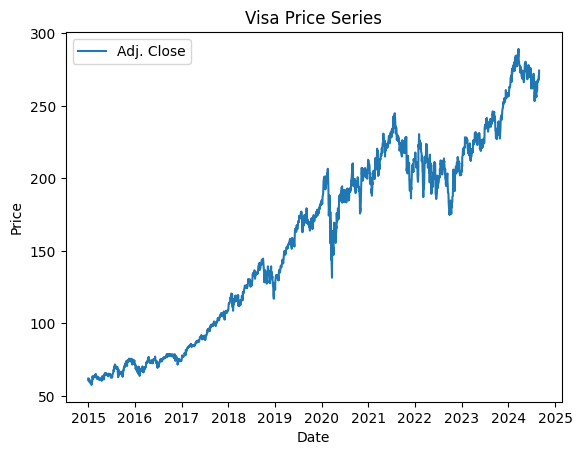

In [8]:
plt.plot(p, label='Adj. Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Visa Price Series')
plt.legend()
plt.show()

In [9]:
# Log Return
r = np.log(p).diff() * 100
print(r)
print("")
print(type(r))

Date
2015-01-02         NaN
2015-01-05   -2.232119
2015-01-06   -0.646440
2015-01-07    1.330914
2015-01-08    1.332353
                ...   
2024-08-23   -0.186783
2024-08-26    0.287497
2024-08-27    0.931486
2024-08-28   -0.566762
2024-08-29    1.887788
Name: Adj Close, Length: 2431, dtype: float64

<class 'pandas.core.series.Series'>


In [10]:
r = r[1:]   # the day 1 return is missing ('NaN') since it requires the day 0 price, so we remove it.
print(r)
print(r.describe())

Date
2015-01-05   -2.232119
2015-01-06   -0.646440
2015-01-07    1.330914
2015-01-08    1.332353
2015-01-09   -1.493431
                ...   
2024-08-23   -0.186783
2024-08-26    0.287497
2024-08-27    0.931486
2024-08-28   -0.566762
2024-08-29    1.887788
Name: Adj Close, Length: 2430, dtype: float64
count    2430.000000
mean        0.061270
std         1.547585
min       -14.557135
25%        -0.655620
50%         0.135002
75%         0.828285
max        12.964701
Name: Adj Close, dtype: float64


In [11]:
print(np.quantile(r, [0.001, 0.005, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995, 0.999]))

[-7.61010119 -5.08316035 -4.42861293 -1.52544177 -0.65562028  0.13500169
  0.82828529  1.59079591  4.21563545  5.30781029  9.77826039]


In [12]:
print(r.skew())
print(r.kurtosis())

-0.06978369607720848
9.730237658126462


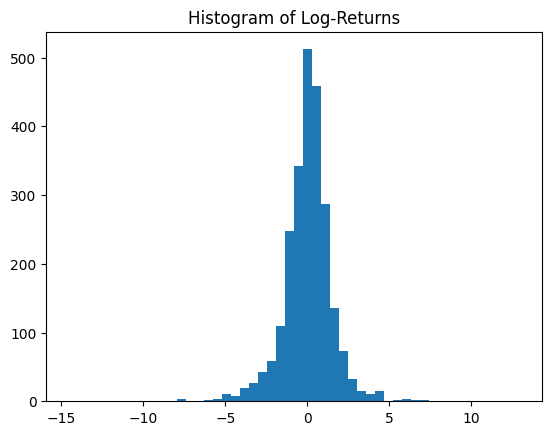

In [13]:
plt.hist(r, 50)
plt.title('Histogram of Log-Returns')
plt.show()

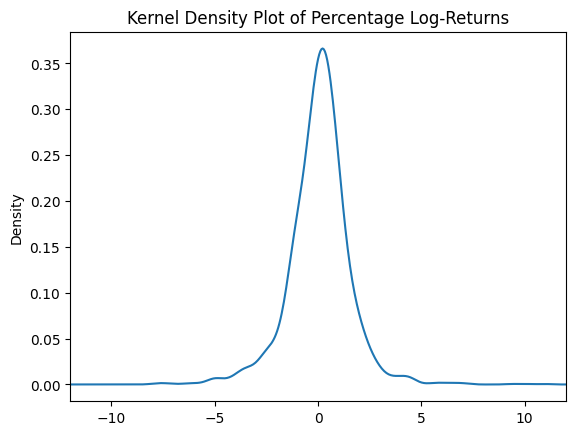

In [14]:
r.plot.kde()
plt.title('Kernel Density Plot of Percentage Log-Returns')
plt.xlim(-12, 12) # NB these liimts are approx the min, max of the data
plt.show()

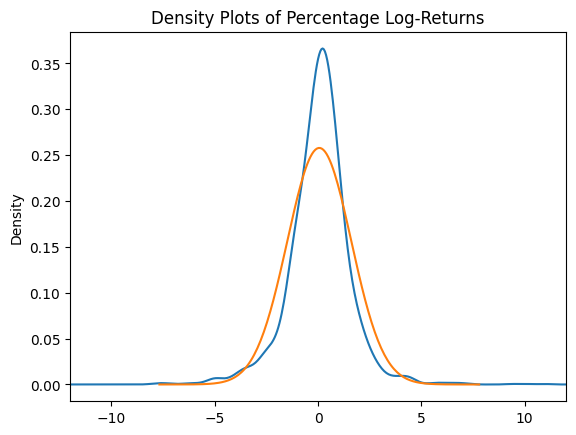

In [15]:
r.plot.kde()  # blue
plt.title('Density Plots of Percentage Log-Returns')
plt.xlim(-12, 12) 

# We can add a Gaussian distribution
r_vec = r.values
x = np.linspace(r.mean() - 5*np.std(r_vec), r.mean() + 5*np.std(r_vec), 200)
plt.plot(x, stats.norm.pdf(x, r.mean(), np.std(r_vec)))  # orange
plt.show()

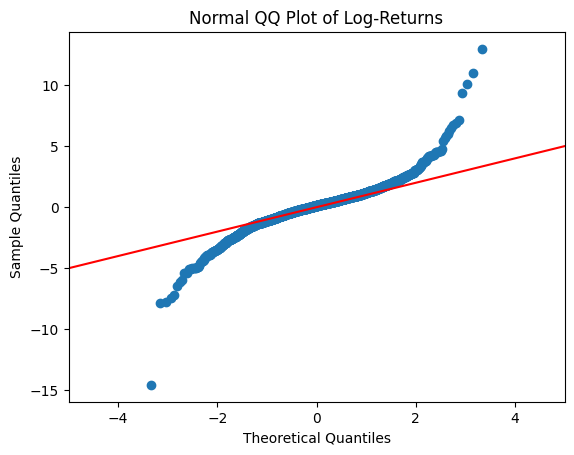

In [16]:
sm.qqplot(r, line='45')
plt.title('Normal QQ Plot of Log-Returns')
plt.xlim(-5, 5)
plt.show()

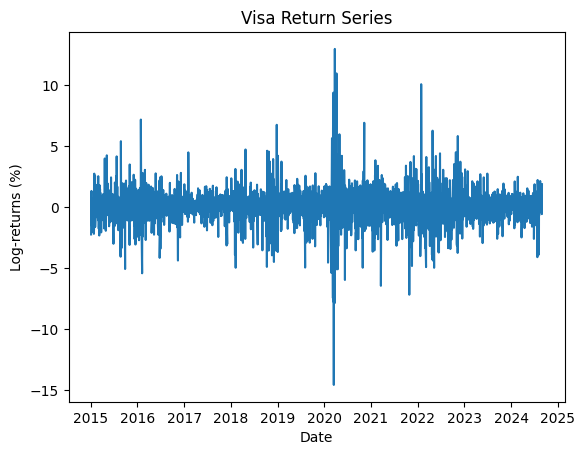

In [17]:
plt.plot(r)
plt.xlabel('Date')
plt.ylabel('Log-returns (%)')
plt.title('Visa Return Series')
plt.show()

** The variance seems to be high during 2020

### Extreme tails

In [18]:
r_vec = r.values
r_std = (r_vec - np.mean(r_vec)) / np.std(r_vec)
print(np.quantile(r_std, 0.001))
print(stats.norm.ppf(0.001))
print(stats.t.ppf(0.001, df=6))

-4.958014876315787
-3.090232306167813
-5.207626238838044


In [19]:
print(np.quantile(r_std, 0.999))
print(stats.norm.ppf(0.999))
print(stats.t.ppf(0.999, df=8))

6.2801000496553625
3.090232306167813
4.500790933725044


The sample quantiles are much closer to those implied by the t distribution than those implied by the normal distribution. Therefore a t distribution is better for modelling the tails of the distribution of returns.


In [20]:
# Under Gaussian
np.mean(r_vec)+np.std(r_vec) * stats.norm.ppf(0.001)

np.float64(-4.720143320113668)

In [21]:
#Under Student-t
np.mean(r_vec)+np.std(r_vec) * stats.t.ppf(0.001, df=5)

np.float64(-9.057437185035068)

The log prices are too heavy tailed to follow a Gaussian Random Walk.

In [22]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on percentage returns
adf_result = adfuller(r)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

if adf_result[1] < 0.05:
    print("The returns series is stationary.")
else:
    print("The returns series is non-stationary.")

ADF Statistic: -13.431901295217013
p-value: 3.99842735031203e-25
Critical Values: {'1%': np.float64(-3.4330617925579685), '5%': np.float64(-2.8627380367880577), '10%': np.float64(-2.567407764552126)}
The returns series is stationary.


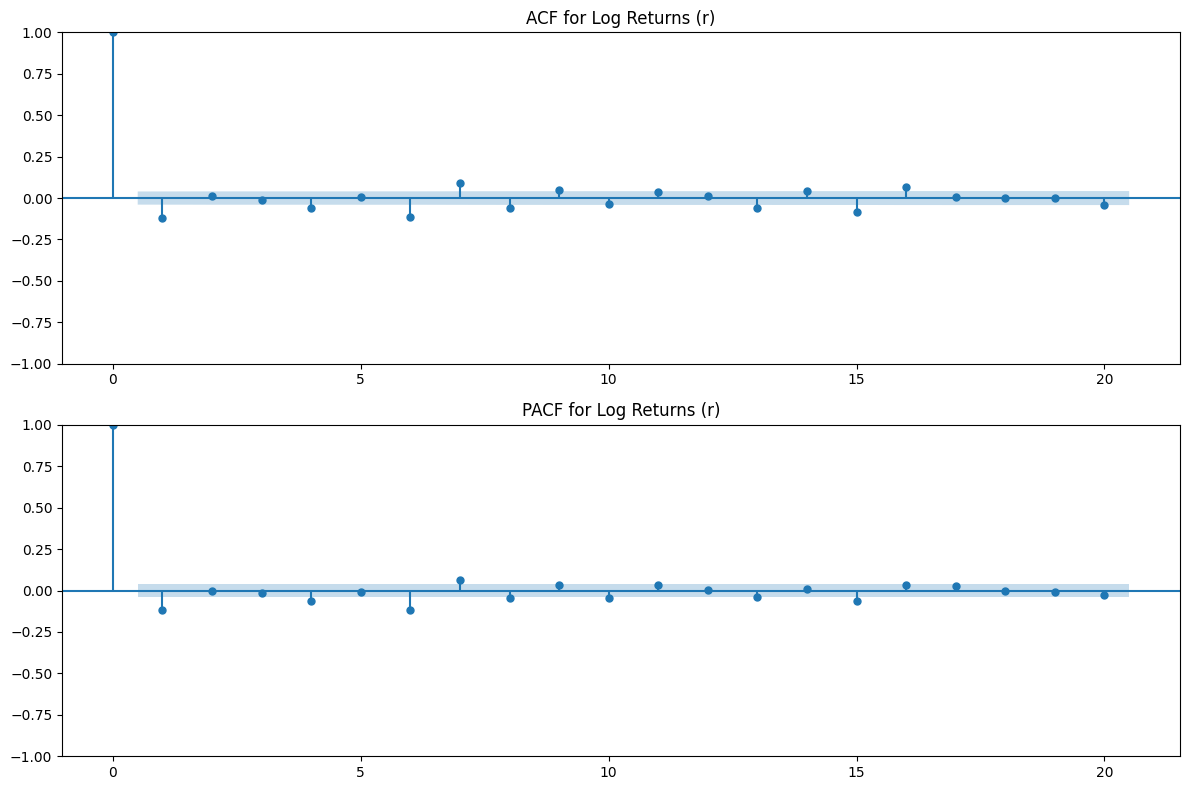

In [23]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig, ax = plt.subplots(2, figsize=(12,8))

sm.graphics.tsa.plot_acf(r.dropna(), lags=20, ax=ax[0])
ax[0].set_title('ACF for Log Returns (r)')

sm.graphics.tsa.plot_pacf(r.dropna(), lags=20, ax=ax[1])
ax[1].set_title('PACF for Log Returns (r)')

plt.tight_layout()
plt.show()


* AR(1) Process: Both plots suggest that the log returns could be modeled as an AR(1) process, where the current value depends mainly on the immediate previous value.
* Since the autocorrelations drop quickly and there are no significant spikes beyond the first lag, the data appears to be stationary

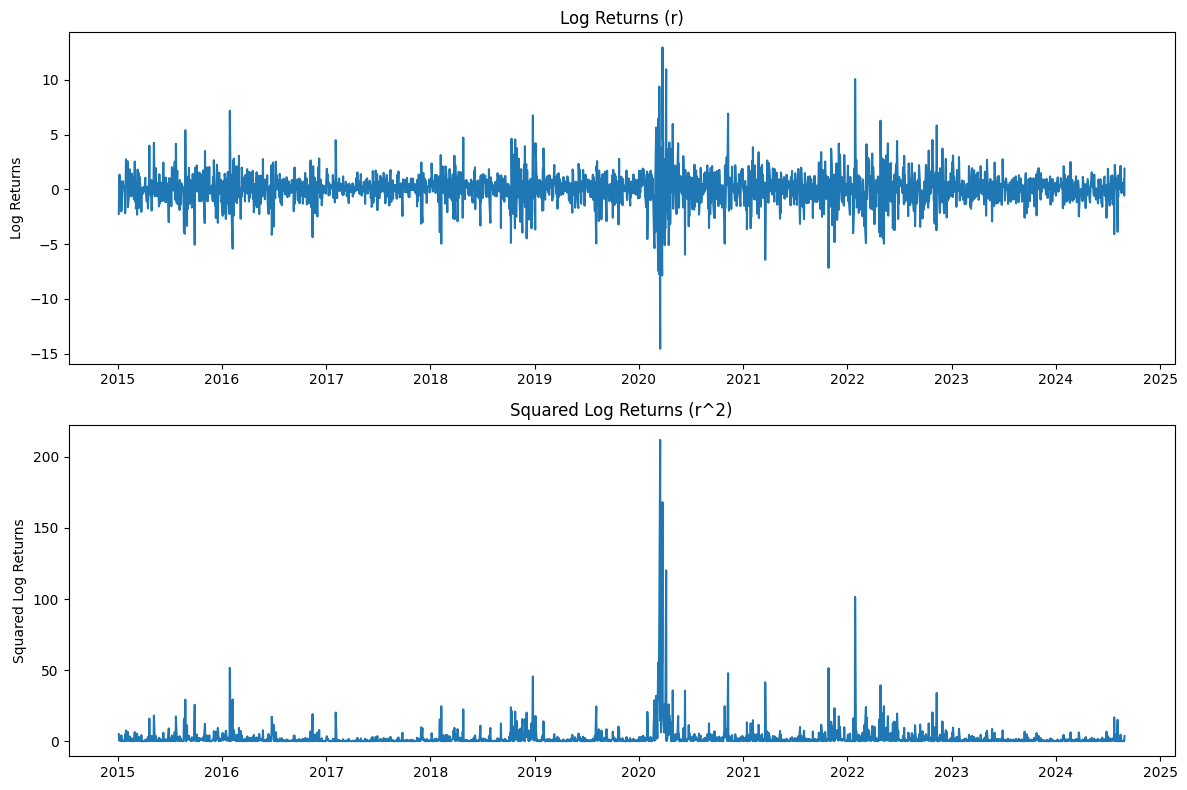

In [24]:
# Plot log returns and squared returns to check for volatility clustering
fig, ax = plt.subplots(2, figsize=(12,8))

ax[0].plot( r, label='Log Returns (r)')
ax[0].set_title('Log Returns (r)')
ax[0].set_ylabel('Log Returns')

ax[1].plot(r**2, label='Squared Log Returns (Volatility Clustering)')
ax[1].set_title('Squared Log Returns (r^2)')
ax[1].set_ylabel('Squared Log Returns')

plt.tight_layout()
plt.show()


* There are clear periods where volatility is elevated (as seen in the squared returns), which is typical for time series that benefit from ARCH/GARCH modeling.
* Major events around 2020 have led to large spikes in volatility. These need to be captured well in the model.

In [25]:
print( "Ljung-Box Q-statistic:" )
for p in [ 5, 10, 15 ]:
    LB_test = acorr_ljungbox( r, lags=[p], return_df = False )
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, float(LB_test.iloc[0,0]), float(LB_test.iloc[0,1]) ) )
print()     

Ljung-Box Q-statistic:
maxlag: 5. Q-stat: 42.890191. P-value: 0.000000
maxlag: 10. Q-stat: 113.841320. P-value: 0.000000
maxlag: 15. Q-stat: 149.262412. P-value: 0.000000



In [26]:
print( "Ljung-Box Q-statistic:" )
for p in [ 5, 10, 15 ]:
    LB_test = acorr_ljungbox( r**2, lags=[p], return_df = False )
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, float(LB_test.iloc[0,0]), float(LB_test.iloc[0,1]) ) )
print()   

Ljung-Box Q-statistic:
maxlag: 5. Q-stat: 811.472780. P-value: 0.000000
maxlag: 10. Q-stat: 1745.276347. P-value: 0.000000
maxlag: 15. Q-stat: 2090.153826. P-value: 0.000000



* The tests are rejected at any level of significance meaning there is strong evidence in favour of conditional heteroskedasticity.

# Parkinson's Range-based Volatility Proxy 

In [27]:
# Compute volatility proxies
rng = 100 * (np.log(df['High']) - np.log(df['Low']))[1:]
rng[rng <= 0] = np.mean([0, np.min(rng[rng > 0])])
ovn = 100 * (np.log(df['Open']) - np.log(df['Close']).shift(1)).dropna()
proxy1 = (r - r.mean()) ** 2
proxy2 = 0.3607 * rng ** 2
proxy3 = 1.107 * proxy2 + 0.68 * ovn ** 2
proxy4 = np.exp(2 * np.log(rng) - 0.86 + 2 * 0.29 ** 2)

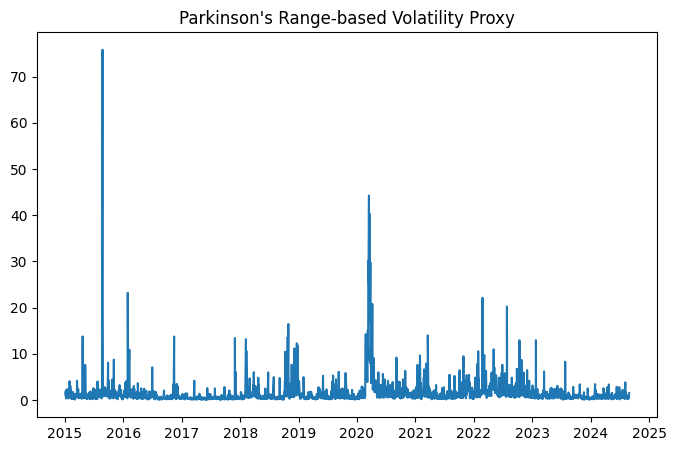

In [28]:
plt.figure(figsize = (8,5))
plt.plot(proxy2)
plt.title("Parkinson's Range-based Volatility Proxy")
plt.show()

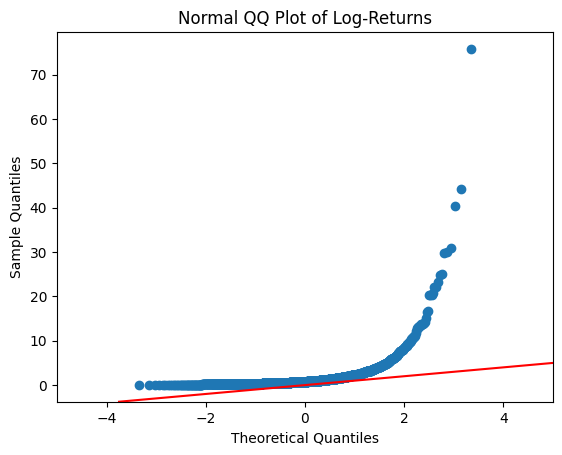

In [29]:
sm.qqplot(proxy2, line='45')
plt.title('Normal QQ Plot of Log-Returns')
plt.xlim(-5, 5)
plt.show()

<Figure size 800x400 with 0 Axes>

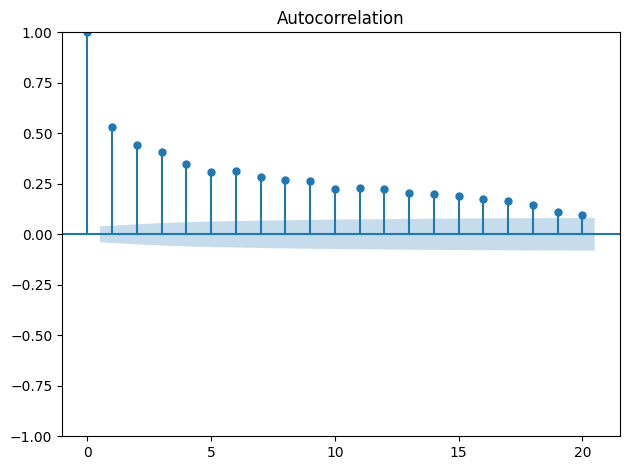

In [30]:
plt.figure(figsize =(8,4))
sm.graphics.tsa.plot_acf(proxy2, lags = 20, alpha = 0.05)
plt.tight_layout()
plt.show()

In [31]:
print ('Ljung-Box Q-Statistic on Log Returns:')
for p in [5, 10, 15]:
    Qstat, pValue = acorr_ljungbox(proxy2, lags=[p], return_df = False).values[0]
    print('maxlag:{0:d}. Q-stat: {1:f}. P-value: {2:f}'.format(p, Qstat, pValue))

Ljung-Box Q-Statistic on Log Returns:
maxlag:5. Q-stat: 2098.074779. P-value: 0.000000
maxlag:10. Q-stat: 3011.697831. P-value: 0.000000
maxlag:15. Q-stat: 3556.047047. P-value: 0.000000


# Model Building

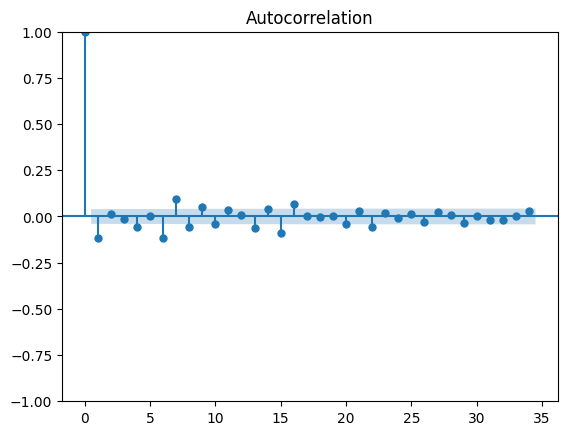

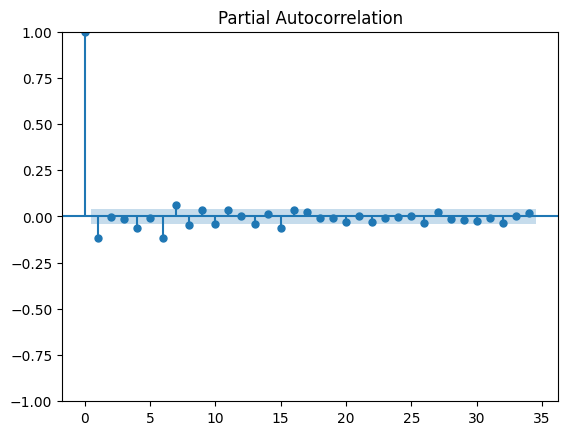

In [32]:
acfplot = sm.graphics.tsa.plot_acf(r)
pacfplot = sm.graphics.tsa.plot_pacf(r)

In [33]:
aic_values = []
bic_values = []
p_values = range(1, 21)

for p in p_values:
    model = sm.tsa.ARIMA(proxy3.dropna(), order=(p, 0, 0)).fit()
    aic_values.append((p, model.aic))
    bic_values.append((p, model.bic))

print("AIC values for different p:")
print(aic_values)

print("BIC values for different p:")
print(bic_values)

# Find the p value with the lowest AIC or BIC
best_p_aic = min(aic_values, key=lambda x: x[1])[0]
best_p_bic = min(bic_values, key=lambda x: x[1])[0]

print(f"Best p according to AIC: {best_p_aic}")
print(f"Best p according to BIC: {best_p_bic}")


AIC values for different p:
[(1, np.float64(15903.291550561547)), (2, np.float64(15685.160391882102)), (3, np.float64(15666.096642397531)), (4, np.float64(15660.103151027448)), (5, np.float64(15634.467038131568)), (6, np.float64(15623.069273836922)), (7, np.float64(15624.350623826842)), (8, np.float64(15626.33095015142)), (9, np.float64(15619.635116828273)), (10, np.float64(15621.617303311261)), (11, np.float64(15623.317444522632)), (12, np.float64(15625.222264463675)), (13, np.float64(15627.142213108718)), (14, np.float64(15626.336601380739)), (15, np.float64(15609.021565677484)), (16, np.float64(15610.70813072673)), (17, np.float64(15611.85346326806)), (18, np.float64(15613.6400224052)), (19, np.float64(15613.243864165664)), (20, np.float64(15615.07968476012))]
BIC values for different p:
[(1, np.float64(15920.67849017055)), (2, np.float64(15708.34297802744)), (3, np.float64(15695.074875079205)), (4, np.float64(15694.877030245456)), (5, np.float64(15675.036563885911)), (6, np.float64

## AR(6)

In [34]:
# Fit AR(6)
r_AR6 = ARIMA(r, order=(6, 0, 0)).fit() 
r_AR6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2430
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -4469.975
Date:                Thu, 24 Oct 2024   AIC                           8955.950
Time:                        20:31:59   BIC                           9002.315
Sample:                             0   HQIC                          8972.807
                               - 2430                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0613      0.025      2.480      0.013       0.013       0.110
ar.L1         -0.1204      0.012    -10.459      0.000      -0.143      -0.098
ar.L2         -0.0105      0.012     -0.895      0.371      -0.033       0.012
ar.L3         -0.0230      0.013     -1.726      0.084      -0.049       0.003
ar.L4         -0.0638      0.014     -4.628      0.000      -0.091      -0.037
ar.L5         -0.0236      0.012     -1.933      0.053      -0.048       0.000
ar.L6         -0.1169      0.011    -10.562      0.000      -0.139      -0.095
sigma2         2.3188      0.036     65.137      0.000       2.249       2.389
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              5578.51
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
print ('Ljung-Box Q-Statistic on Residual:')
for p in [p+5, p+10, p+15]:
    Qstat, pValue = acorr_ljungbox(r_AR6.resid, lags=[p], return_df=False).values[0]
    print('maxlag:{0:d}. Q-stat: {1:f}. P-value: {2:f}'.format(p, Qstat, pValue))

Ljung-Box Q-Statistic on Residual:
maxlag:25. Q-stat: 54.751587. P-value: 0.000530
maxlag:30. Q-stat: 62.886899. P-value: 0.000406
maxlag:35. Q-stat: 68.204863. P-value: 0.000655


## AR(15)

In [36]:
# Fit AR(15)
r_AR15 = ARIMA(r, order=(15, 0, 0)).fit() 
r_AR15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2430
Model:                ARIMA(15, 0, 0)   Log Likelihood               -4449.740
Date:                Thu, 24 Oct 2024   AIC                           8933.479
Time:                        20:32:00   BIC                           9032.005
Sample:                             0   HQIC                          8969.301
                               - 2430                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0613      0.025      2.489      0.013       0.013       0.110
ar.L1         -0.1041      0.014     -7.712      0.000      -0.131      -0.078
ar.L2         -0.0200      0.013     -1.520      0.128      -0.046       0.006
ar.L3         -0.0143      0.016     -0.903      0.367      -0.045       0.017
ar.L4         -0.0671      0.015     -4.388      0.000      -0.097      -0.037
ar.L5         -0.0232      0.014     -1.705      0.088      -0.050       0.003
ar.L6         -0.1059      0.015     -7.258      0.000      -0.135      -0.077
ar.L7          0.0538      0.016      3.464      0.001       0.023       0.084
ar.L8         -0.0389      0.013     -2.888      0.004      -0.065      -0.012
ar.L9          0.0204      0.014      1.427      0.154      -0.008       0.049
ar.L10        -0.0397      0.015     -2.616      0.009      -0.070      -0.010
ar.L11         0.0305      0.017      1.824      0.068      -0.002       0.063
ar.L12        -0.0043      0.016     -0.271      0.787      -0.036       0.027
ar.L13        -0.0415      0.017     -2.420      0.016      -0.075      -0.008
ar.L14         0.0038      0.017      0.232      0.816      -0.029       0.036
ar.L15        -0.0646      0.014     -4.591      0.000      -0.092      -0.037
sigma2         2.2803      0.036     62.841      0.000       2.209       2.351
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4957.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
print ('Ljung-Box Q-Statistic on Residual:')
for p in [p+5, p+10, p+15]:
    Qstat, pValue = acorr_ljungbox(r_AR15.resid, lags=[p], return_df=False).values[0]
    print('maxlag:{0:d}. Q-stat: {1:f}. P-value: {2:f}'.format(p, Qstat, pValue))

Ljung-Box Q-Statistic on Residual:
maxlag:40. Q-stat: 26.758263. P-value: 0.946108
maxlag:45. Q-stat: 34.895305. P-value: 0.861152
maxlag:50. Q-stat: 47.333113. P-value: 0.581040


* Although AR(15) gives a better LB test result, to avoid overfitting problem, we choose AR(6)

## Step2: Finding a volatility model

Now we will assume an AR(6) model for the mean, and test the following models for conditional heteroskedasticy

- GARCH(3,7)

We will choose the best model by AIC.


In [38]:
import numpy as np
from arch import arch_model

ret = r.dropna()

p_range = range(1, 10)  # GARCH terms
q_range = range(1, 10)  # ARCH terms

best_aic = np.inf
best_pq = (0, 0)

for p in p_range:
    for q in q_range:
        try:
            res = arch_model(ret, mean='AR', lags=15, vol='GARCH', p=p, q=q).fit(disp="off")
 
            print(f"p={p}, q={q}, AIC={res.aic}")

            if res.aic < best_aic:
                best_aic = res.aic
                best_pq = (p, q)
        except Exception as e:
            print(f"Error for p={p}, q={q}: {e}")

print(f"Optimal p, q: {best_pq} with AIC: {best_aic}")

p=1, q=1, AIC=8218.376590699447
p=1, q=2, AIC=8220.099451220012
p=1, q=3, AIC=8220.124649705258
p=1, q=4, AIC=8221.794912892656
p=1, q=5, AIC=8223.0650904954
p=1, q=6, AIC=8222.771079537826
p=1, q=7, AIC=8223.789756917402
p=1, q=8, AIC=8225.78975735158
p=1, q=9, AIC=8227.789756989849
p=2, q=1, AIC=8220.376590685999
p=2, q=2, AIC=8221.0132894145
p=2, q=3, AIC=8216.250347155375
p=2, q=4, AIC=8217.45256701018
p=2, q=5, AIC=8219.452567004872
p=2, q=6, AIC=8219.976646242516
p=2, q=7, AIC=8217.782270214684
p=2, q=8, AIC=8219.782270735082
p=2, q=9, AIC=8221.782270913835
p=3, q=1, AIC=8222.37659080285
p=3, q=2, AIC=8223.013289421471
p=3, q=3, AIC=8218.250346758225
p=3, q=4, AIC=8217.779461729955
p=3, q=5, AIC=8219.779461432585
p=3, q=6, AIC=8221.308452862895
p=3, q=7, AIC=8215.73702777473
p=3, q=8, AIC=8217.737028216312
p=3, q=9, AIC=8219.737028364201
p=4, q=1, AIC=8224.376591161456
p=4, q=2, AIC=8225.013289433533
p=4, q=3, AIC=8220.250346908439
p=4, q=4, AIC=8219.779462239072
p=4, q=5, AIC=82

In [39]:
resid = r_AR15.resid 
res_GARCH37_resid = arch_model(resid, vol = 'GARCH', p=3, q=7, dist='Normal').fit(disp ='off')
res_GARCH37_resid.arch_lm_test (standardized = True)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 26.7197
P-value: 0.4790
Distributed: chi2(27)
WaldTestStatistic, id: 0x16933e500

The null is that the standardised residuals are homoskedastic. With a p-value of 0.4790 (which is greater than 0.05) so we fail to reject the null. There is insufficient evidence to suggest that conditional heteroskedasticty remains in the data after fitting a GARCH(3,7). The GARCH(3,7) is an adequate volatility model for Visa returns.

## Step3: Finding a distribution

In [40]:
res_AR6_GARCH37_t = arch_model(r, mean='AR',lags=6, vol='GARCH',p=3,q=7,dist='StudentsT').fit(disp="off")
res_AR6_GARCH37_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                    Adj Close   R-squared:                       0.011
Mean Model:                              AR   Adj. R-squared:                  0.008
Vol Model:                            GARCH   Log-Likelihood:               -3990.34
Distribution:      Standardized Student's t   AIC:                           8018.69
Method:                  Maximum Likelihood   BIC:                           8128.76
                                              No. Observations:                 2424
Date:                      Thu, Oct 24 2024   Df Residuals:                     2417
Time:                              20:32:13   Df Model:                            7
                                   Mean Model                                   
================================================================================
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const            0.1559  2.330e-02      6.692  2.204e-11       [  0.110,  0.202]
Adj Close[1]    -0.0690  2.060e-02     -3.351  8.044e-04    [ -0.109,-2.865e-02]
Adj Close[2]    -0.0476  2.107e-02     -2.261  2.379e-02 [-8.892e-02,-6.333e-03]
Adj Close[3]    -0.0510  2.087e-02     -2.443  1.455e-02 [-9.189e-02,-1.009e-02]
Adj Close[4]    -0.0523  1.947e-02     -2.686  7.238e-03 [-9.044e-02,-1.413e-02]
Adj Close[5]    -0.0441  1.918e-02     -2.302  2.136e-02 [-8.173e-02,-6.551e-03]
Adj Close[6]    -0.0106  1.942e-02     -0.545      0.586  [-4.864e-02,2.748e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1524      0.143      1.067      0.286   [ -0.127,  0.432]
alpha[1]       0.1187  5.098e-02      2.328  1.991e-02 [1.877e-02,  0.219]
alpha[2]       0.1582      0.166      0.950      0.342   [ -0.168,  0.485]
alpha[3]       0.0817      0.145      0.562      0.574   [ -0.203,  0.367]
beta[1]        0.0000      1.626      0.000      1.000   [ -3.188,  3.188]
beta[2]        0.0000      0.988      0.000      1.000   [ -1.937,  1.937]
beta[3]        0.3100      0.555      0.558      0.577   [ -0.778,  1.398]
beta[4]    2.4814e-14      0.777  3.192e-14      1.000   [ -1.523,  1.523]
beta[5]        0.0000      0.508      0.000      1.000   [ -0.997,  0.997]
beta[6]        0.0854      0.360      0.237      0.812   [ -0.620,  0.791]
beta[7]        0.2004      0.545      0.368      0.713   [ -0.868,  1.269]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.6018      0.445     10.338  4.727e-25 [  3.729,  5.474]
========================================================================

Covariance estimator: robust
"""

In [41]:
res_AR6_GARCH37_n = arch_model(r, mean='AR',lags=6, vol='GARCH',p=3,q=7,dist='Normal').fit(disp="off")
res_AR6_GARCH37_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.020
Mean Model:                        AR   Adj. R-squared:                  0.018
Vol Model:                      GARCH   Log-Likelihood:               -4099.24
Distribution:                  Normal   AIC:                           8234.48
Method:            Maximum Likelihood   BIC:                           8338.76
                                        No. Observations:                 2424
Date:                Thu, Oct 24 2024   Df Residuals:                     2417
Time:                        20:32:13   Df Model:                            7
                                   Mean Model                                   
================================================================================
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const            0.1152  7.897e-02      1.459      0.144    [-3.954e-02,  0.270]
Adj Close[1]    -0.0692  4.757e-02     -1.454      0.146     [ -0.162,2.408e-02]
Adj Close[2]    -0.0342  2.384e-02     -1.433      0.152  [-8.088e-02,1.256e-02]
Adj Close[3]    -0.0383  9.363e-02     -0.409      0.683       [ -0.222,  0.145]
Adj Close[4]    -0.0451  2.210e-02     -2.042  4.120e-02 [-8.842e-02,-1.803e-03]
Adj Close[5]    -0.0366  6.713e-02     -0.546      0.585     [ -0.168,9.494e-02]
Adj Close[6]    -0.0393  2.246e-02     -1.748  8.047e-02  [-8.326e-02,4.761e-03]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.1392      0.427      0.326      0.744 [ -0.697,  0.976]
alpha[1]       0.1140      0.496      0.230      0.818 [ -0.858,  1.086]
alpha[2]       0.1473      0.279      0.528      0.597 [ -0.399,  0.694]
alpha[3]       0.0415      0.133      0.313      0.755 [ -0.219,  0.302]
beta[1]    4.4306e-10      7.575  5.849e-11      1.000 [-14.847, 14.847]
beta[2]    5.3285e-10      7.268  7.331e-11      1.000 [-14.246, 14.246]
beta[3]        0.4063      5.299  7.668e-02      0.939 [ -9.979, 10.792]
beta[4]    4.3092e-10      7.972  5.405e-11      1.000 [-15.625, 15.625]
beta[5]    5.4078e-10      4.910  1.101e-10      1.000 [ -9.624,  9.624]
beta[6]    4.3117e-10      0.708  6.094e-10      1.000 [ -1.387,  1.387]
beta[7]        0.2342      0.853      0.274      0.784 [ -1.439,  1.907]
========================================================================

Covariance estimator: robust
"""

In [42]:
pd.DataFrame([[res_AR6_GARCH37_n.aic,res_AR6_GARCH37_t.aic],
               [res_AR6_GARCH37_n.bic,res_AR6_GARCH37_t.bic]],
             index = ['AIC', 'BIC'],
             columns = ['Gaussian', 'StudentT']).round(1)

,Gaussian,StudentT
AIC,8234.5,8018.7
BIC,8338.8,8128.8


-The AIC and BIC become smaller under the Student T distribution when compared to the Gaussian case, indicating Student T performs better.

(np.float64(841.9229056604787), np.float64(1.5092595822234033e-183), np.float64(-0.39010870643236056), np.float64(5.779771778714347))


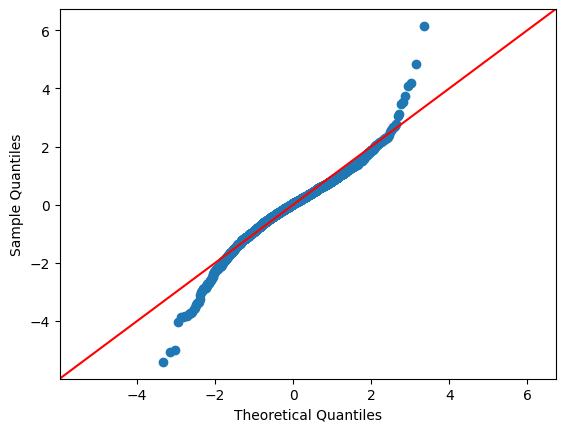

In [43]:
stdresid_normal = res_AR6_GARCH37_n.std_resid.dropna()
qq_norm = sm.qqplot(stdresid_normal,line='45')
jb_norm = jarque_bera(stdresid_normal)
print(jb_norm)

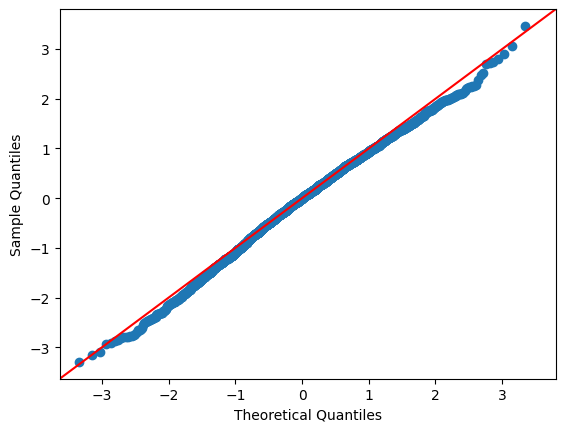

In [44]:
stdresid_t = res_AR6_GARCH37_t.std_resid

df = res_AR6_GARCH37_t.params['nu']
stdresid_t = res_AR6_GARCH37_t.std_resid.dropna()
stdresid_t_unif = stats.t.cdf(np.sqrt(df / (df - 2)) * stdresid_t, df)
stdresid_t_trans = stats.norm.ppf(stdresid_t_unif)
qq_t = sm.qqplot(stdresid_t_trans,line='45')

In [45]:
jb_t = jarque_bera(stdresid_t_trans)
print(jb_t)

(np.float64(16.056507839818757), np.float64(0.00032611713872052385), np.float64(-0.19678678943494157), np.float64(2.936162995353226))


The Jarque-Bera test strongly rejects the null hypothesis of normality, confirming that the residuals are not normally distributed.

In [46]:
# OLS estimation of ARCH(1) 
mu = r.mean()
a2 = (r[1:] - mu) ** 2
a2_lag = (r[:-1] - mu) ** 2
x = sm.add_constant(a2_lag.values)
ols = sm.OLS(a2,x).fit(cov_type='HC0')
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.026
Date:                Thu, 24 Oct 2024   Prob (F-statistic):             0.0251
Time:                        20:32:14   Log-Likelihood:                -8422.0
No. Observations:                2429   AIC:                         1.685e+04
Df Residuals:                    2427   BIC:                         1.686e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6206      0.267      6.063      0.0

In [47]:
arch1 = arch_model(r, mean='Constant', vol='ARCH', dist='normal', p=1)
arch1_fit = arch1.fit()
print(arch1_fit.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3193187807576.858
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1365943651.6030607
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4448.021104141678
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4300.555191502171
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4300.384864738803
Iteration:      6,   Func. Count:     33,   Neg. LLF: 4300.384860723909
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4300.384860723914
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4300.384860723909
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelih

In [48]:
a0 = arch1_fit.params['omega']
a11 = arch1_fit.params['alpha[1]']
unc_var = a0 / (1-a11)

a0_ols = ols.params['const']
a1_ols = ols.params['x1']
unc_var_ols = a0_ols / (1-a1_ols)

smp_var = r.var()

print(smp_var, unc_var, unc_var_ols)

2.39502000577965 2.354199662122254 2.3924774599242937


In [49]:
smp_kurt = kurtosis(r, fisher=False)
unc_kurt = 3 * (1 - a11 ** 2) / (1 - 3 * a11 ** 2)

unc_kurt_ls = 3 * (1 - a1_ols ** 2) / (1 - 3 * a1_ols ** 2)


print(smp_kurt, unc_kurt, unc_kurt_ls)

12.707760004252517 4.266864145449803 3.908247351527891


## Proxy2

In [50]:
import statsmodels.api as sm

p_values = range(1, 20)

aic_values = []
bic_values = []

for p in p_values:
    try:
        model = sm.tsa.ARIMA(proxy2.dropna(), order=(p, 0, 0)).fit()
        aic_values.append((p, model.aic))
        bic_values.append((p, model.bic))
    except:
        pass

best_p_aic = min(aic_values, key=lambda x: x[1])[0]
best_p_bic = min(bic_values, key=lambda x: x[1])[0]

print(f"Best p according to AIC: {best_p_aic}")
print(f"Best p according to BIC: {best_p_bic}")


Best p according to AIC: 9
Best p according to BIC: 6


In [51]:
from arch import arch_model

proxy2 = proxy2.dropna()

p_range = range(1, 10)
q_range = range(1, 10)

# Store the best model based on AIC
best_aic = float('inf')
best_pq = (0, 0)

for p in p_range:
    for q in q_range:
        try:
            model = arch_model(proxy2, mean='AR', lags=best_p_aic, vol='GARCH', p=p, q=q).fit(disp='off')
            print(f"p={p}, q={q}, AIC={model.aic}")

            if model.aic < best_aic:
                best_aic = model.aic
                best_pq = (p, q)
        except:
            pass

print(f"Optimal p and q for GARCH on proxy2: {best_pq} with AIC: {best_aic}")


p=1, q=1, AIC=9310.518975993367
p=1, q=2, AIC=9309.230782804603
p=1, q=3, AIC=9311.230764468477
p=1, q=4, AIC=9313.230769784515
p=1, q=5, AIC=9314.078912659717
p=1, q=6, AIC=9312.34859683959
p=1, q=7, AIC=9291.710683693766
p=1, q=8, AIC=9279.160316422272
p=1, q=9, AIC=9281.159219423724
p=2, q=1, AIC=9312.518971558518
p=2, q=2, AIC=9310.326101748713
p=2, q=3, AIC=9312.326121597096
p=2, q=4, AIC=9314.32614433541
p=2, q=5, AIC=9315.26888544778
p=2, q=6, AIC=9314.34864408833
p=2, q=7, AIC=9293.709085593726
p=2, q=8, AIC=9279.252383848803


/Users/nickshang/anaconda3/envs/QBUS6830/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


p=2, q=9, AIC=9281.257919846761
p=3, q=1, AIC=9308.696177954203
p=3, q=2, AIC=9310.69617302738
p=3, q=3, AIC=9312.69618119496
p=3, q=4, AIC=9314.695777064098
p=3, q=5, AIC=9317.40824393339
p=3, q=6, AIC=9314.91035878317
p=3, q=7, AIC=9294.9396044399
p=3, q=8, AIC=9276.800349714213
p=3, q=9, AIC=9278.800732168083
p=4, q=1, AIC=9310.696177451046
p=4, q=2, AIC=9312.696181386884
p=4, q=3, AIC=9314.69610208178
p=4, q=4, AIC=9316.696183365722
p=4, q=5, AIC=9318.150118185187
p=4, q=6, AIC=9316.909235068455
p=4, q=7, AIC=9296.939327677894
p=4, q=8, AIC=9278.800199223657
p=4, q=9, AIC=9280.80060419378
p=5, q=1, AIC=9312.696221819566
p=5, q=2, AIC=9314.696239977802
p=5, q=3, AIC=9316.696179845161
p=5, q=4, AIC=9318.696169777997
p=5, q=5, AIC=9320.15011865365
p=5, q=6, AIC=9318.907307483047
p=5, q=7, AIC=9298.937902414857
p=5, q=8, AIC=9280.800741654717
p=5, q=9, AIC=9282.800589690843
p=6, q=1, AIC=9314.595930618474
p=6, q=2, AIC=9316.5958875069
p=6, q=3, AIC=9318.59582360569
p=6, q=4, AIC=9320.5

/Users/nickshang/anaconda3/envs/QBUS6830/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


p=9, q=7, AIC=9298.053419599426
p=9, q=8, AIC=9288.403100537274
p=9, q=9, AIC=9290.403440752418
Optimal p and q for GARCH on proxy2: (3, 8) with AIC: 9276.800349714213


In [52]:
# Fit AR(6)
proxy2_AR6 = ARIMA(r, order=(6, 0, 0)).fit() 
proxy2_AR6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2430
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -4469.975
Date:                Thu, 24 Oct 2024   AIC                           8955.950
Time:                        20:32:50   BIC                           9002.315
Sample:                             0   HQIC                          8972.807
                               - 2430                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0613      0.025      2.480      0.013       0.013       0.110
ar.L1         -0.1204      0.012    -10.459      0.000      -0.143      -0.098
ar.L2         -0.0105      0.012     -0.895      0.371      -0.033       0.012
ar.L3         -0.0230      0.013     -1.726      0.084      -0.049       0.003
ar.L4         -0.0638      0.014     -4.628      0.000      -0.091      -0.037
ar.L5         -0.0236      0.012     -1.933      0.053      -0.048       0.000
ar.L6         -0.1169      0.011    -10.562      0.000      -0.139      -0.095
sigma2         2.3188      0.036     65.137      0.000       2.249       2.389
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              5578.51
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
resid1 = proxy2_AR6.resid 
res_GARCH37_resid = arch_model(resid1, vol = 'GARCH', p=3, q=7, dist='Normal').fit(disp ='off')
res_GARCH37_resid.arch_lm_test (standardized = True)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 26.9446
P-value: 0.4668
Distributed: chi2(27)
WaldTestStatistic, id: 0x16933f4f0

In [54]:
proxy2_AR6_GARCH37_t = arch_model(proxy2, mean='AR',lags=6, vol='GARCH',p=3,q=7,dist='StudentsT').fit(disp="off")
proxy2_AR6_GARCH37_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                         None   R-squared:                       0.262
Mean Model:                              AR   Adj. R-squared:                  0.260
Vol Model:                            GARCH   Log-Likelihood:               -3116.50
Distribution:      Standardized Student's t   AIC:                           6271.00
Method:                  Maximum Likelihood   BIC:                           6381.07
                                              No. Observations:                 2424
Date:                      Thu, Oct 24 2024   Df Residuals:                     2417
Time:                              20:32:51   Df Model:                            7
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.2073  1.951e-02     10.622  2.348e-26      [  0.169,  0.245]
None[1]        0.1923  1.879e-02     10.234  1.402e-24      [  0.156,  0.229]
None[2]        0.0822  1.436e-02      5.725  1.033e-08    [5.407e-02,  0.110]
None[3]        0.0858  1.399e-02      6.136  8.472e-10    [5.840e-02,  0.113]
None[4]        0.0238  1.420e-02      1.674  9.407e-02 [-4.056e-03,5.160e-02]
None[5]        0.0538  1.329e-02      4.051  5.107e-05  [2.779e-02,7.989e-02]
None[6]        0.0654  1.489e-02      4.391  1.128e-05  [3.619e-02,9.455e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.3741      0.218      1.717  8.599e-02 [-5.296e-02,  0.801]
alpha[1]       0.3326      0.157      2.122  3.383e-02  [2.541e-02,  0.640]
alpha[2]       0.2560      0.275      0.930      0.352    [ -0.283,  0.795]
alpha[3]       0.0771      0.144      0.537      0.591    [ -0.204,  0.359]
beta[1]        0.0000      0.986      0.000      1.000    [ -1.932,  1.932]
beta[2]    4.9956e-11      0.289  1.726e-10      1.000    [ -0.567,  0.567]
beta[3]        0.0172      0.124      0.138      0.890    [ -0.226,  0.261]
beta[4]        0.3037      0.175      1.734  8.300e-02 [-3.966e-02,  0.647]
beta[5]    4.0552e-11      0.339  1.197e-10      1.000    [ -0.664,  0.664]
beta[6]    1.8638e-10      0.223  8.361e-10      1.000    [ -0.437,  0.437]
beta[7]        0.0135      0.130      0.103      0.918    [ -0.242,  0.269]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.2730  8.746e-02     25.988 6.776e-149 [  2.102,  2.444]
========================================================================

Covariance estimator: robust
"""

In [55]:
proxy2_AR6_GARCH37_n = arch_model(proxy2, mean='AR',lags=6, vol='GARCH',p=3,q=7,dist='Normal').fit(disp="off")
proxy2_AR6_GARCH37_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                   None   R-squared:                       0.312
Mean Model:                        AR   Adj. R-squared:                  0.311
Vol Model:                      GARCH   Log-Likelihood:               -4704.48
Distribution:                  Normal   AIC:                           9444.97
Method:            Maximum Likelihood   BIC:                           9549.24
                                        No. Observations:                 2424
Date:                Thu, Oct 24 2024   Df Residuals:                     2417
Time:                        20:32:51   Df Model:                            7
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.2275      0.111      2.048  4.058e-02  [9.762e-03,  0.445]
None[1]        0.2283      0.157      1.457      0.145 [-7.874e-02,  0.535]
None[2]        0.2714      0.125      2.174  2.972e-02  [2.669e-02,  0.516]
None[3]        0.1747  9.139e-02      1.912  5.589e-02 [-4.396e-03,  0.354]
None[4]        0.0239      0.313  7.650e-02      0.939    [ -0.589,  0.637]
None[5]        0.0858  7.513e-02      1.142      0.254 [-6.147e-02,  0.233]
None[6]        0.0879      0.138      0.636      0.525    [ -0.183,  0.359]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.2110      2.695      0.449      0.653 [ -4.072,  6.494]
alpha[1]       0.8431      0.279      3.027  2.468e-03 [  0.297,  1.389]
alpha[2]       0.0530      0.825  6.429e-02      0.949 [ -1.563,  1.669]
alpha[3]       0.0414      0.711  5.814e-02      0.954 [ -1.353,  1.435]
beta[1]    1.1350e-09      0.932  1.218e-09      1.000 [ -1.826,  1.826]
beta[2]    1.4432e-09      0.798  1.809e-09      1.000 [ -1.564,  1.564]
beta[3]        0.0000      0.342      0.000      1.000 [ -0.671,  0.671]
beta[4]        0.0625  9.231e-02      0.677      0.499 [ -0.118,  0.243]
beta[5]        0.0000  8.056e-02      0.000      1.000 [ -0.158,  0.158]
beta[6]    4.9264e-10      0.101  4.889e-09      1.000 [ -0.197,  0.197]
beta[7]    7.4479e-14      0.138  5.399e-13      1.000 [ -0.270,  0.270]
========================================================================

Covariance estimator: robust
"""

In [56]:
pd.DataFrame([[proxy2_AR6_GARCH37_n.aic,proxy2_AR6_GARCH37_t.aic],
               [proxy2_AR6_GARCH37_n.bic,proxy2_AR6_GARCH37_t.bic]],
             index = ['AIC', 'BIC'],
             columns = ['Gaussian', 'StudentT']).round(1)

,Gaussian,StudentT
AIC,9445.0,6271.0
BIC,9549.2,6381.1


(np.float64(593094.7344221813), np.float64(0.0), np.float64(6.344488792307089), np.float64(78.57258061721912))


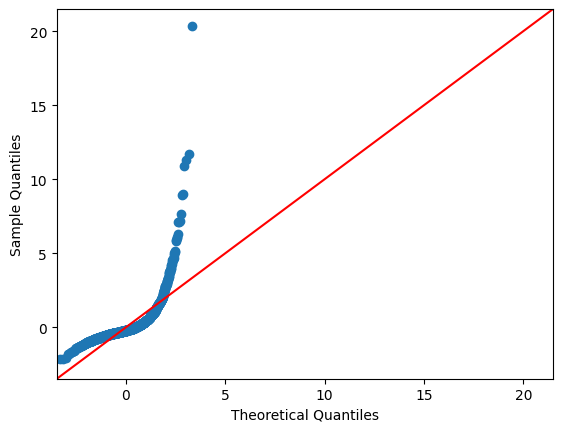

In [57]:
stdresid_normal1 = proxy2_AR6_GARCH37_n.std_resid.dropna()
qq_norm = sm.qqplot(stdresid_normal1,line='45')
jb_norm = jarque_bera(stdresid_normal1)
print(jb_norm)

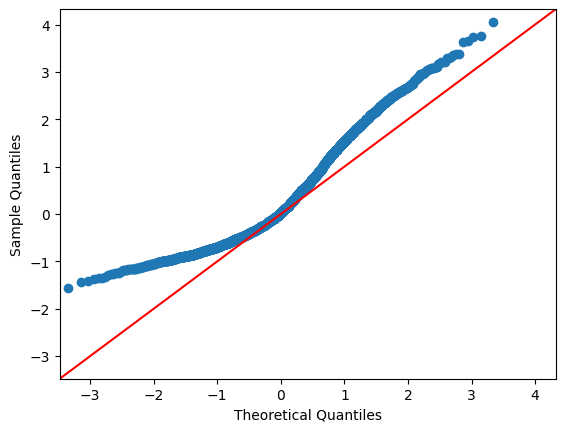

In [58]:
stdresid_t1 = proxy2_AR6_GARCH37_t.std_resid

df = proxy2_AR6_GARCH37_t.params['nu']
stdresid_t1 = proxy2_AR6_GARCH37_t.std_resid.dropna()
stdresid_t1_unif = stats.t.cdf(np.sqrt(df / (df - 2)) * stdresid_t1, df)
stdresid_t1_trans = stats.norm.ppf(stdresid_t1_unif)
qq_t = sm.qqplot(stdresid_t1_trans,line='45')

In [59]:
jb_t = jarque_bera(stdresid_t1_trans)
print(jb_t)

(np.float64(250.4344425447807), np.float64(4.1576867183376835e-55), np.float64(0.7786981065634618), np.float64(2.767479094649846))


# Forcast Validation

#### 1)Compare ARCH(1)-Normal with a constant mean to a AR(6)-GARCH(3,7)-T to fit Log Return

        

In [60]:
# Total 
number_all = len (r)

# Number of windows
number_wind = 500

# Size of each window
size_wind = number_all - number_wind

## Forecasting

In [61]:
# Define function 

# Normal VaR
def qn(p):
    return stats.norm.ppf(p)

# Normal Expected Shortfall 
def esn(p):
    ninv = stats.norm.ppf(p)
    return - stats.norm.pdf(ninv)/p

# StudentsT VaR
def qt(p,df):
    return stats.t.ppf(p,df) * np.sqrt((df - 2) / df)
                        
# StudentsT ES
def est(p,df):
    tinv = stats.t.ppf(p,df)
    f = lambda x: stats.t.pdf(x,df)
    return -f(tinv) / p * (df + tinv **2) / (df - 1) * np.sqrt((df-2)/df)


##### 1-step Ahead Forecast

In [62]:
# ARCH(1)-N
farch_mean = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_sd = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_var1 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_var25 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_es1 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
farch_es25 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')

# AR(6)-GARCH(3,7)-T 
fgarch_mean = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_sd = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_var1 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_var25 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_es1 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
fgarch_es25 = pd.Series(index = r[-number_wind:].index, dtype = 'float64')
# store the value of degree of freedom as we use t-distribution 
fgarch_df = pd.Series(index = r[-number_wind:].index, dtype = 'float64')

# Forecasting Method - Expanding Window
for i in tqdm(range(number_wind)): 
    train = r[:(size_wind+i+1)]

    #ARCH(1)-n
    res_ARCH1_n = arch_model(train, mean = 'Constant', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off') #Training
    fc_ARCH1_n = res_ARCH1_n.forecast(horizon = 1, reindex = False) # Forecast
    
    # Result 
    mean = fc_ARCH1_n.mean
    sd = np.sqrt(fc_ARCH1_n.variance)

    var1 = -(mean + sd *qn(0.01))
    var25 = -(mean + sd *qn(0.025))
    es1= -(mean + sd *esn(0.01))
    es25 = -(mean + sd *esn(0.025))

    # Storge 
    farch_mean[i] = mean.iloc[0,0]
    farch_sd[i] = sd.iloc[0,0]
    farch_var1[i] = var1.iloc[0,0]
    farch_var25[i] = var25.iloc[0,0]
    farch_es1[i] = es1.iloc[0,0]
    farch_es25[i] = es25.iloc[0,0]

    
    # AR(6)-GARCH(3,7)-t
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 1, reindex = False)  
 
    # Result - Assume there is a distribution
    mean = fc_AR6_GARCH37_t.mean
    sd = np.sqrt(fc_AR6_GARCH37_t.variance)
    df = res_AR6_GARCH37_t.params['nu']
    var1 = -(mean + sd * qt(0.01, df))
    var25 = -(mean + sd * qt(0.025, df))
    es1= -(mean + sd *est(0.01, df))
    es25 = -(mean + sd *est(0.025, df))

    # Storge 
    fgarch_mean[i] = mean.iloc[0,0]
    fgarch_sd[i] = sd.iloc[0,0]
    fgarch_var1[i] = var1.iloc[0,0]
    fgarch_var25[i] = var25.iloc[0,0]
    fgarch_es1[i] = es1.iloc[0,0]
    fgarch_es25[i] = es25.iloc[0,0]

    fgarch_df[i] = df
  


  0%|          | 0/500 [00:00<?, ?it/s]

- For 10-step ahead and 22-step ahead forecasts we will use simulation. Since we forecast more than 1 step ahead, there are more than one residuals we need to think about, therefore the distribution is uncertain. 

##### 10-step Ahead Forcast

In [63]:
# ARCH(1)-N 
farch_mean_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_sd_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_var1_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_var25_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_es1_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
farch_es25_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')

# AR(8)-GARCH(3,7)-T
fgarch_mean_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_sd_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_var1_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_var25_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_es1_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
fgarch_es25_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')
# store the value of degree of freedom as we use t-distribution 
fgarch_df_h10 = pd.Series(index = r[-number_wind+9:].index, dtype = 'float64')

# Number of future scenarios to stimulate. Since we don't know the joint distrubution, we need to stimulate 
B = 10000


# Expanding Window
for i in tqdm(range(number_wind-9)): 
    train = r[:(size_wind+i+1)]

    #ARCH(1)-n
    res_ARCH1_n = arch_model(train, mean = 'Constant', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off')
    fc_ARCH1_n = res_ARCH1_n.forecast(horizon = 10, method = 'simulation', simulations = B, reindex = False)
    
    # Result 
    mean = fc_ARCH1_n.mean[['h.10']]
    sd = np.sqrt(fc_ARCH1_n.variance[['h.10']])

    simvals = fc_ARCH1_n.simulations.values[0,:,9]
    var1 = - np.quantile(simvals, 0.01)
    var25 = - np.quantile(simvals, 0.025)
    es1= - np.mean(simvals[(simvals<=-var1)])
    es25 = - np.mean(simvals[(simvals<=-var25)])

    # Storge 
    farch_mean_h10[i] = mean.iloc[0,0]
    farch_sd_h10[i] = sd.iloc[0,0]
    farch_var1_h10[i] = var1
    farch_var25_h10[i] = var25
    farch_es1_h10[i] = es1
    farch_es25_h10[i] = es25

    # AR(6)-GARCH(3,7)-t
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 10, method = 'simulation', simulations = B, reindex = False)
    
    # Result - Sampling from the uncertain distribution and based on the samples to calculate 
    mean = fc_AR6_GARCH37_t.mean[['h.10']]
    sd = np.sqrt(fc_AR6_GARCH37_t.variance[['h.10']])
    df = res_AR6_GARCH37_t.params['nu']

    simvals = fc_AR6_GARCH37_t.simulations.values[0,:,9] # 
    var1 = - np.quantile(simvals, 0.01)
    var25 = - np.quantile(simvals, 0.025)
    es1= - np.mean(simvals[(simvals<=-var1)])
    es25 = - np.mean(simvals[(simvals<=-var25)])

    # Storge 
    fgarch_mean_h10[i] = mean.iloc[0,0]
    fgarch_sd_h10[i] = sd.iloc[0,0]
    fgarch_var1_h10[i] = var1
    fgarch_var25_h10[i] = var25
    fgarch_es1_h10[i] = es1
    fgarch_es25_h10[i] = es25

    fgarch_df_h10[i] = df

  0%|          | 0/491 [00:00<?, ?it/s]

##### 22-step Ahead Forcast

In [64]:
# ARCH(1)- N
farch_mean_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_sd_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_var1_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_var25_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_es1_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
farch_es25_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')

# AR(6)-GARCH(3,7)- T
fgarch_mean_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_sd_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_var1_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_var25_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_es1_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
fgarch_es25_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')
# store the value of degree of freedom as we use t-distribution 
fgarch_df_h22 = pd.Series(index = r[-number_wind+21:].index, dtype = 'float64')

# Number of future scenarios to stimulate
B = 10000


# Expanding Window
for i in tqdm(range(number_wind-21)): 
    train = r[:(size_wind+i+1)]

    #ARCH(1)-n
    res_ARCH1_n = arch_model(train, mean = 'Constant', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off')
    fc_ARCH1_n = res_ARCH1_n.forecast(horizon = 22, method = 'simulation', simulations = B, reindex = False)
    
    # Result 
    mean = fc_ARCH1_n.mean[['h.22']]
    sd = np.sqrt(fc_ARCH1_n.variance[['h.22']])

    simvals = fc_ARCH1_n.simulations.values[0,:,21]
    var1 = - np.quantile(simvals, 0.01)
    var25 = - np.quantile(simvals, 0.025)
    es1= - np.mean(simvals[(simvals<=-var1)])
    es25 = - np.mean(simvals[(simvals<=-var25)])

    # Storge 
    farch_mean_h22[i] = mean.iloc[0,0]
    farch_sd_h22[i] = sd.iloc[0,0]
    farch_var1_h22[i] = var1
    farch_var25_h22[i] = var25
    farch_es1_h22[i] = es1
    farch_es25_h22[i] = es25

    
    # AR(6)-GARCH(3,7)-t
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 22, method = 'simulation', simulations = B, reindex = False)
    
    # Result 
    mean = fc_AR6_GARCH37_t.mean[['h.22']]
    sd = np.sqrt(fc_AR6_GARCH37_t.variance[['h.22']])
    df = res_AR6_GARCH37_t.params['nu']

    simvals = fc_AR6_GARCH37_t.simulations.values[0,:,21]
    var1 = - np.quantile(simvals, 0.01)
    var25 = - np.quantile(simvals, 0.025)
    es1= - np.mean(simvals[(simvals<=-var1)])
    es25 = - np.mean(simvals[(simvals<=-var25)])

    # Storge 
    fgarch_mean_h22[i] = mean.iloc[0,0]
    fgarch_sd_h22[i] = sd.iloc[0,0]
    fgarch_var1_h22[i] = var1
    fgarch_var25_h22[i] = var25
    fgarch_es1_h22[i] = es1
    fgarch_es25_h22[i] = es25

    fgarch_df_h22[i] = df

  0%|          | 0/479 [00:00<?, ?it/s]

# Validation

### Mean 

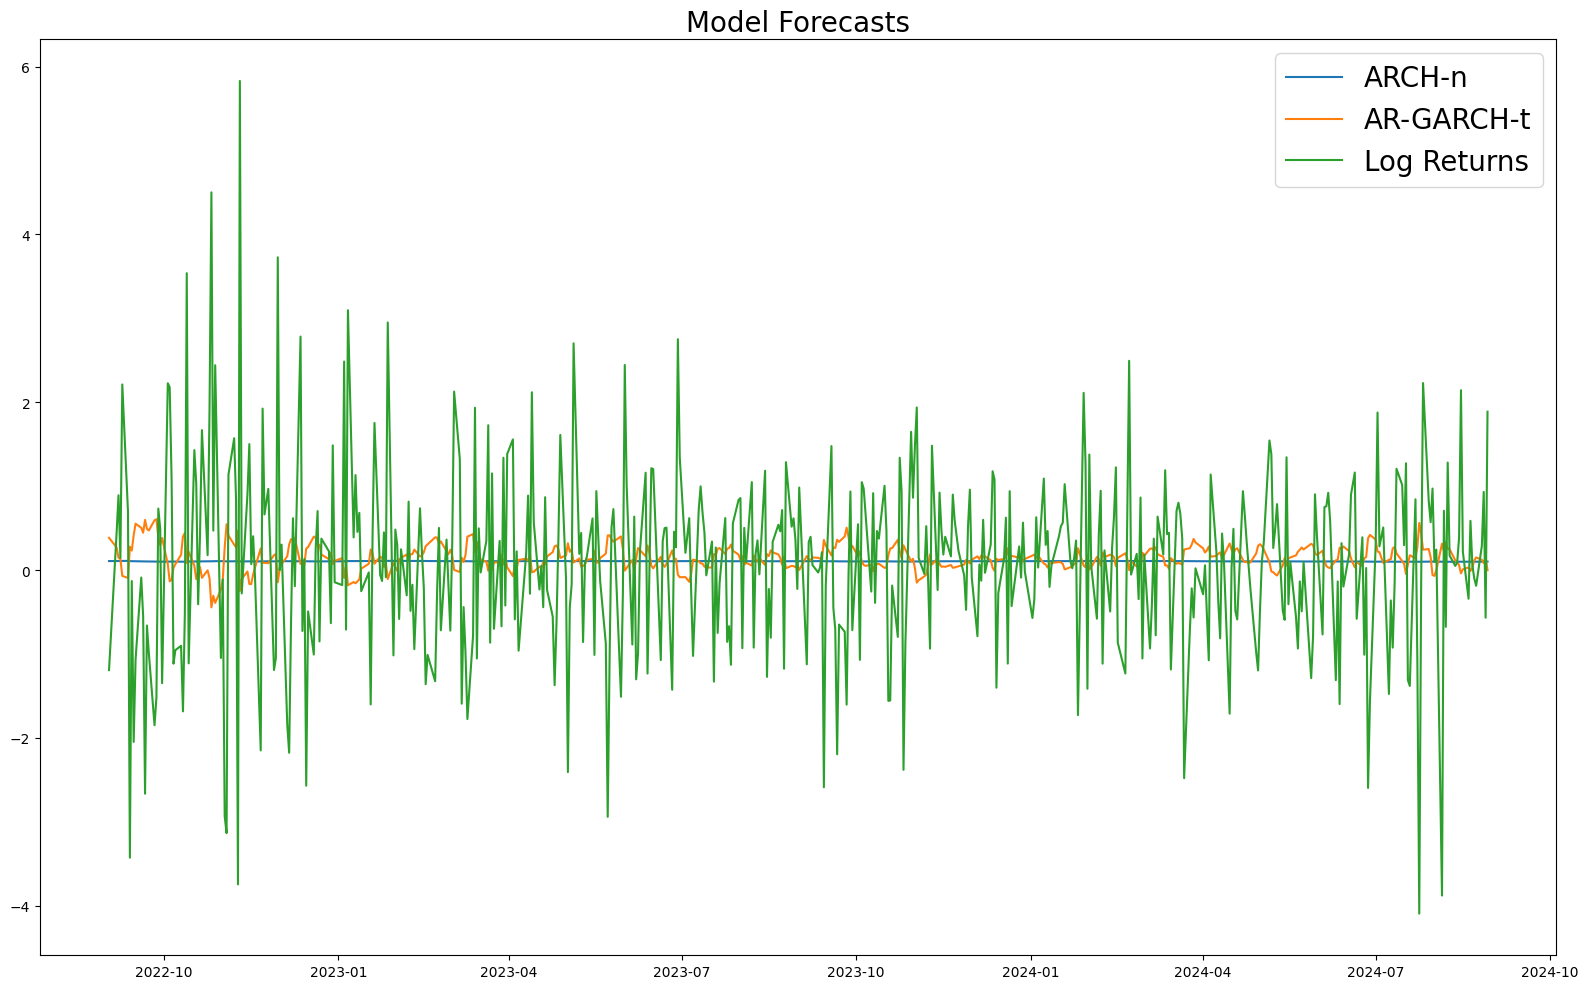

In [65]:
# h = 1 
y_val = r[-500:]

# plot 
plt.figure(figsize = (16,10))
plt.plot(farch_mean, label = 'ARCH-n')
plt.plot(fgarch_mean, label = 'AR-GARCH-t')
plt.plot(y_val, label = 'Log Returns')
plt.title('Model Forecasts', fontsize=20)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()

# RMSE
rmse_arch_mean = np.sqrt(np.mean((y_val-farch_mean)**2))
rmse_garch_mean = np.sqrt(np.mean((y_val-fgarch_mean)**2))

In [66]:
# h = 10 
y_val = r[-491:]

# RMSE
rmse_arch_mean_h10 = np.sqrt(np.mean((y_val-farch_mean_h10)**2))
rmse_garch_mean_h10 = np.sqrt(np.mean((y_val-fgarch_mean_h10)**2))

# h = 22
y_val = r[-479:]

# RMSE
rmse_arch_mean_h22 = np.sqrt(np.mean((y_val-farch_mean_h22)**2))
rmse_garch_mean_h22 = np.sqrt(np.mean((y_val-fgarch_mean_h22)**2))

In [67]:
mdl_name = ['ARCH-n','AR-GARCH-t']
horizon = [1,10,22]
rmse = [[rmse_arch_mean,rmse_garch_mean],
        [rmse_arch_mean_h10,rmse_garch_mean_h10],
        [rmse_arch_mean_h22,rmse_garch_mean_h22],]
tbl_rmse_mean = pd.DataFrame(rmse, index = horizon, columns = mdl_name)
tbl_rmse_mean.index.name = 'Horizon'
tbl_rmse_mean.round(4)

,ARCH-n,AR-GARCH-t
Horizon,,
1,1.1305,1.2258
10,1.1193,1.1200
22,1.1101,1.1104


##### Conclusion: For the mean validation, we can conclude that the ARCH model is better, which means there is no improvement using AR-GARCH-t

### Variance/ Volatility

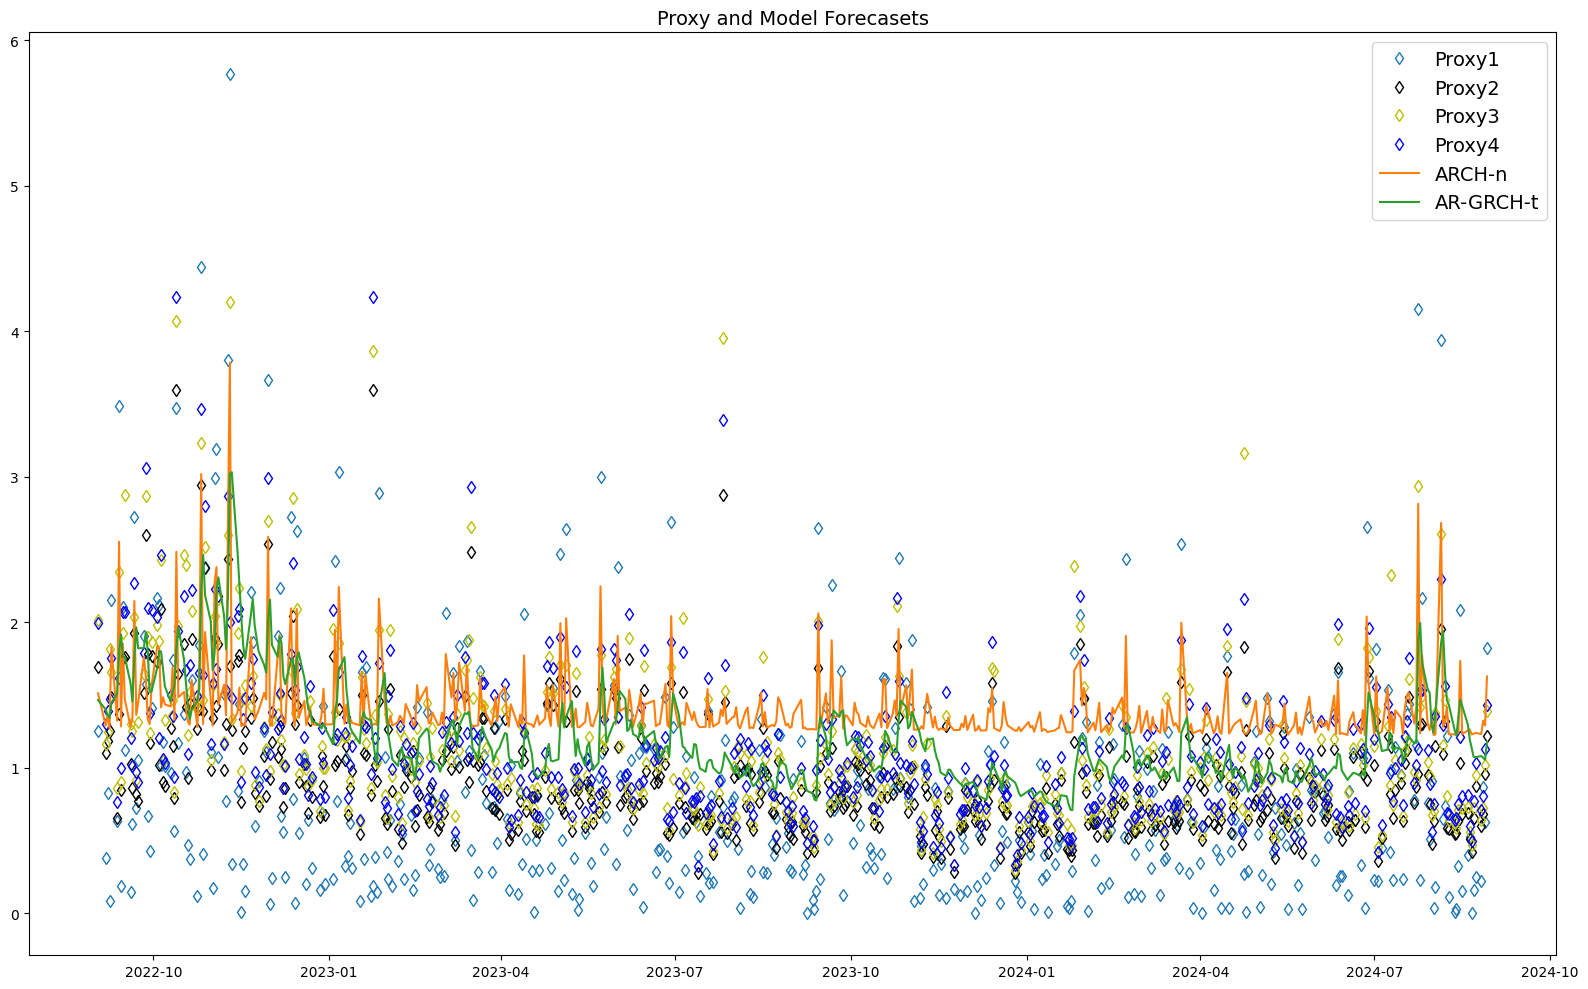

,Horizon,Proxy1,Proxy2,Proxy3,Proxy4,Avg Rank
ARCH-n,1,0.7779,0.6007,0.5324,0.5305,2.0
AR-GARCH-t,1,0.7751,0.4791,0.4773,0.4612,1.0


In [68]:
# h =1 
f_proxy1 = proxy1[-500:]
f_proxy2 = proxy2[-500:]
f_proxy3 = proxy3[-500:]
f_proxy4 = proxy4[-500:]

#plot 
plt.figure(figsize=(16,10))
plt.plot(np.sqrt(f_proxy1),'d',mfc='none',label='Proxy1')
plt.plot(np.sqrt(f_proxy2),'kd',mfc='none',label='Proxy2')
plt.plot(np.sqrt(f_proxy3),'yd',mfc='none',label='Proxy3')
plt.plot(np.sqrt(f_proxy4),'bd',mfc='none',label='Proxy4')

plt.plot(farch_sd, label= 'ARCH-n')
plt.plot(fgarch_sd, label= 'AR-GRCH-t')

plt.title('Proxy and Model Forecasets', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# RMSE
f_model = np.vstack([farch_sd, fgarch_sd]).T
f_proxy = np.sqrt(np.vstack([f_proxy1,f_proxy2,f_proxy3,f_proxy4]).T)

n_model = f_model.shape[1]
n_proxy = f_proxy.shape[1]
f_model_rep = f_model.repeat(n_proxy, axis = 1)
f_proxy_rep = np.tile(f_proxy, [1,n_model])
rmse = np.sqrt(np.mean((f_model_rep - f_proxy_rep)**2, axis = 0)).reshape(n_model,-1)

mdl_name = ['ARCH-n', 'AR-GARCH-t']
prx_name = ['Proxy1','Proxy2','Proxy3','Proxy4']
tbl_rmse_sd = pd.DataFrame(rmse, index=mdl_name, columns= prx_name)
tbl_rmse_sd.insert(0,'Horizon',[1,1])

# Add Rank 
rk_rmse1 = rankdata(rmse[:,0])
rk_rmse2 = rankdata(rmse[:,1])
rk_rmse3 = rankdata(rmse[:,2])
rk_rmse4 = rankdata(rmse[:,3])

# Assign equal weighting to Proxy 2, Proxy 3, Proxy 4, and assign the rest weighting to Proxy 1
rk_rmse_avg = (0.3 * rk_rmse4 + 0.3 * rk_rmse3 + 0.3 * rk_rmse2 + 0.1 * rk_rmse1)
tbl_rmse_sd['Avg Rank'] = rk_rmse_avg
tbl_rmse_sd.round(4)

-Based on the table, we can see that, for one-step ahead forecast, all the RMSE value to the corresponding Proxy for the AR-GARCH model are smaller than ARCH's. 

In [69]:
# h = 10
f_proxy1_h10 = proxy1[-491:]
f_proxy2_h10 = proxy2[-491:]
f_proxy3_h10 = proxy3[-491:]
f_proxy4_h10 = proxy4[-491:]

# RMSE
f_model_h10 = np.vstack([farch_sd_h10, fgarch_sd_h10]).T
f_proxy_h10 = np.sqrt(np.vstack([f_proxy1_h10,f_proxy2_h10,f_proxy3_h10,f_proxy4_h10]).T)

n_model = f_model_h10.shape[1]
n_proxy = f_proxy_h10.shape[1]
f_model_rep_h10 = f_model_h10.repeat(n_proxy, axis = 1)
f_proxy_rep_h10 = np.tile(f_proxy_h10, [1,n_model])
rmse_h10 = np.sqrt(np.mean((f_model_rep_h10 - f_proxy_rep_h10)**2, axis = 0)).reshape(n_model,-1)

mdl_name = ['ARCH-n', 'AR-GARCH-t']
prx_name = ['Proxy1','Proxy2','Proxy3','Proxy4']
tbl_rmse_sd_h10 = pd.DataFrame(rmse_h10, index=mdl_name, columns= prx_name)
tbl_rmse_sd_h10.insert(0,'Horizon',[10,10])

# Add Rank 
rk_rmse1 = rankdata(rmse_h10[:,0])
rk_rmse2 = rankdata(rmse_h10[:,1])
rk_rmse3 = rankdata(rmse_h10[:,2])
rk_rmse4 = rankdata(rmse_h10[:,3])

rk_rmse_avg = (0.3 * rk_rmse4 + 0.3 * rk_rmse3 + 0.3 * rk_rmse2 + 0.1 * rk_rmse1)

tbl_rmse_sd_h10['Avg Rank'] = rk_rmse_avg
tbl_rmse_sd_h10.round(4)

,Horizon,Proxy1,Proxy2,Proxy3,Proxy4,Avg Rank
ARCH-n,10,1.0717,0.7863,0.7337,0.7072,2.0
AR-GARCH-t,10,0.9184,0.6020,0.5837,0.5554,1.0


In [70]:
# h = 22
f_proxy1_h22 = proxy1[-479:]
f_proxy2_h22 = proxy2[-479:]
f_proxy3_h22 = proxy3[-479:]
f_proxy4_h22 = proxy4[-479:]

# RMSE
f_model_h22 = np.vstack([farch_sd_h22, fgarch_sd_h22]).T
f_proxy_h22 = np.sqrt(np.vstack([f_proxy1_h22,f_proxy2_h22,f_proxy3_h22,f_proxy4_h22]).T)

n_model = f_model_h22.shape[1]
n_proxy = f_proxy_h22.shape[1]
f_model_rep_h22 = f_model_h22.repeat(n_proxy, axis = 1)
f_proxy_rep_h22 = np.tile(f_proxy_h22, [1,n_model])
rmse_h22 = np.sqrt(np.mean((f_model_rep_h22 - f_proxy_rep_h22)**2, axis = 0)).reshape(n_model,-1)

mdl_name = ['ARCH-n', 'AR-GARCH-t']
prx_name = ['Proxy1','Proxy2','Proxy3','Proxy4']
tbl_rmse_sd_h22 = pd.DataFrame(rmse_h22, index=mdl_name, columns= prx_name)
tbl_rmse_sd_h22.insert(0,'Horizon',[22,22])

# Add Rank 
rk_rmse1 = rankdata(rmse_h22[:,0])
rk_rmse2 = rankdata(rmse_h22[:,1])
rk_rmse3 = rankdata(rmse_h22[:,2])
rk_rmse4 = rankdata(rmse_h22[:,3])

rk_rmse_avg = (0.3 * rk_rmse4 + 0.3 * rk_rmse3 + 0.3 * rk_rmse2 + 0.1 * rk_rmse1)

tbl_rmse_sd_h22['Avg Rank'] = rk_rmse_avg
tbl_rmse_sd_h22.round(4)

,Horizon,Proxy1,Proxy2,Proxy3,Proxy4,Avg Rank
ARCH-n,22,1.0790,0.7939,0.7389,0.7114,2.0
AR-GARCH-t,22,0.9966,0.6947,0.6486,0.6198,1.0


In [71]:
# Summary 
tbl_rmse_sd_all = pd.concat([tbl_rmse_sd, tbl_rmse_sd_h10,tbl_rmse_sd_h22])
tbl_rmse_sd_all.reset_index(names=['Module'], inplace=True)
tbl_rmse_sd_all = tbl_rmse_sd_all.groupby(['Horizon','Module']).mean()
tbl_rmse_sd_all.round(4)

Proxy1  Proxy2  Proxy3  Proxy4  Avg Rank
Horizon Module                                              
1       AR-GARCH-t  0.7751  0.4791  0.4773  0.4612       1.0
        ARCH-n      0.7779  0.6007  0.5324  0.5305       2.0
10      AR-GARCH-t  0.9184  0.6020  0.5837  0.5554       1.0
        ARCH-n      1.0717  0.7863  0.7337  0.7072       2.0
22      AR-GARCH-t  0.9966  0.6947  0.6486  0.6198       1.0
        ARCH-n      1.0790  0.7939  0.7389  0.7114       2.0

##### Conclusion: For the variance validation, we can conclude that the AR-GARCH-t model alwayes performs better than ARCH-n under all the forecasting horizon.

# VaR

In [72]:
def uctest (viol, a):
    n = len(viol)
    p = np.sum(viol) / n
    z = (p-a) / np.sqrt(a*(1-a)/n)
    pval = 2 * stats.norm.sf(np.abs(z))
    return pval, p 


def indtest (viol):
    try:
        n = len(viol)

        r5 = viol[1:]
        r51 = viol[:-1]
        i11 = r5*r51
        i01 = r5*(1-r51)
        i10=(1-r5)*r51
        i00 = (1-r5)*(1-r51)

        t00 = np.sum(i00)
        t01 = np.sum(i01)
        t10 = np.sum(i10)
        t11 = np.sum(i11)
        p01 = t01 / (t00+t01)
        p11 = t11 / (t10+t11)
        p1 = (t01+t11)/n 
        ll1 = t00 * np.log(1-p01) + (p01>0)*t01*np.log(p01)+t10*np.log(1-p11)
        if p11 > 0:
            ll1 = ll1 + t11 * np.log(p11)
        
        ll0 = (t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)
        lrid=2*(ll1 - ll0)
        pcc = 1-stats.chi2.cdf(lrid,1)
    except:
        pcc = np.nan
        lrid = np.nan
    return pcc, lrid

# Dynamic quantile test
def dqtest(y, var, a, lag):
    n = len(y)
    hits = ((-y > var) * 1)  
    q = 2 + lag

    if np.sum(hits) > 0:  
        ns = n - lag
        xmat = np.column_stack([np.ones((ns, 1)), var[lag:n]])
        for k in range(1, lag + 1):
            lk = lag - k
            xmat = np.column_stack([xmat, hits[lk:n-k]])

        hx = np.dot(hits[lag:], xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond=None)[0]
        
        
        dq = np.dot(hx, np.dot(xtx, hx.T))
        dq = dq / (a * (1 - a))  
        pdq = 1 - stats.chi2.cdf(dq, q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq


# Pinball Loss Function 
def qloss(q, r, p):
    q = - np.array(q)
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    l = p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)
    return l

# Accuracy checks for VaR
def check_var_fc(var_fc, r, p):
    viol = -r > var_fc
    n_viol = np.sum(viol)
    pval_uc, p_hat = uctest(viol, p)
    pval_ind = indtest(viol)[0]
    pval_dq = dqtest(r, var_fc, p, 4)[0]
    qtl_loss = qloss(var_fc, r, p)
    return [n_viol, p_hat, pval_uc, pval_ind, pval_dq, qtl_loss]

##### 1-step ahead  
- 1% VaR 

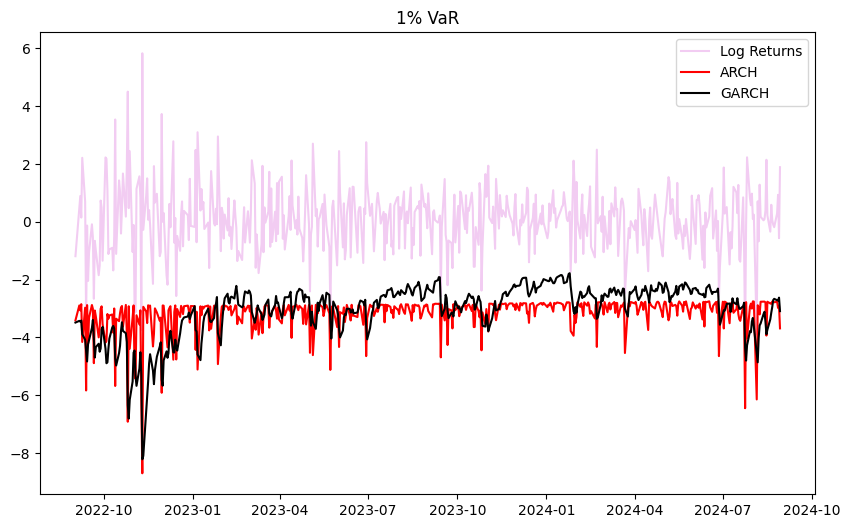

In [73]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-500:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var1, 'r', label = 'ARCH') # negative sign just for revieing the graph 
plt.plot(-fgarch_var1, 'k', label = 'GARCH')

plt.title('1% VaR')
plt.legend()
plt.show()

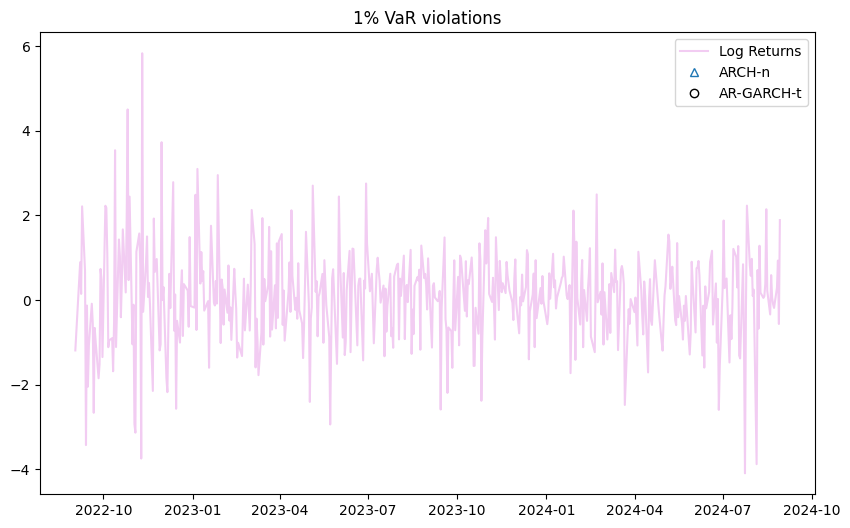

In [74]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-500:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-500:][r[-500:] < -farch_var1],'^', mfc = 'none', label = 'ARCH-n')
plt.plot(r[-500:][r[-500:] < -farch_var1],'ko', mfc = 'none', label = 'AR-GARCH-t')

plt.legend()
plt.title('1% VaR violations')
plt.show()

##### Conclusion: Using 1% VaR, we can see nothing violated under the two models, which means that this risk management strategy is too conservative. The advantage of this conservative strategy is that it's not easy to have financial crisis, but the disadvantage is preparing too much cash for extreme events happened. 

In [75]:
# Forecast accuracy checks 
tbl_var1 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var1, r[-500:], 0.01),
    'AR-GARCH-t': check_var_fc(fgarch_var1, r[-500:],0.01)},
     index = ['Viol.(5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var1.insert(0, 'Horizon', [1,1])
tbl_var1.round(4)
    

,Horizon,Viol.(5),$\hat{p}$,UC,Ind,DQ,Q Loss
ARCH-n,1,0.0,0.0,0.0246,NaN,NaN,16.2551
AR-GARCH-t,1,0.0,0.0,0.0246,NaN,NaN,15.5754


##### Comment: Both models fail the unconditional coverage test(p-value < 0.05). If these VaR forecasts are used, too much cash will be held against risky assets that could better invested elsewhere. With no violation, independence and DQ test are useless, but based on the Q Loss, we can see that AR-GARCH model is smaller than ARCH model, which means it's better than ARCH.

- 2.5% VaR 

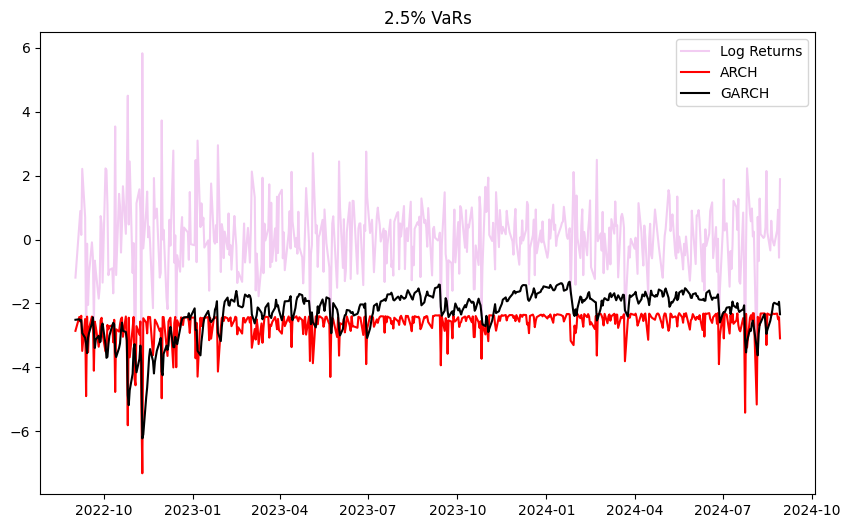

In [76]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-500:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var25, 'r', label = 'ARCH') 
plt.plot(-fgarch_var25, 'k', label = 'GARCH')

plt.title('2.5% VaRs')
plt.legend()
plt.show()

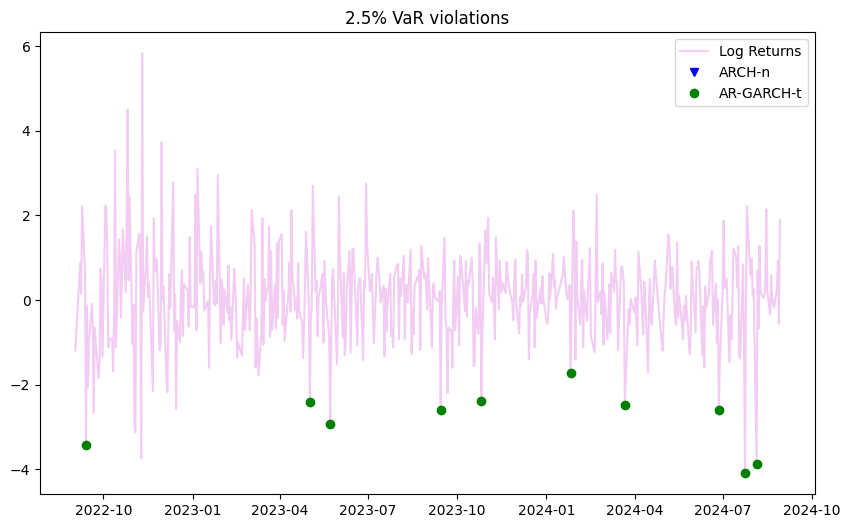

In [77]:
# VaR violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-500:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-500:][r[-500:] < -farch_var25], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-500:][r[-500:] < -fgarch_var25], 'o', color='green', label='AR-GARCH-t')


plt.legend()
plt.title('2.5% VaR violations')
plt.show()

In [78]:
# forecast accuracy checks 
tbl_var25 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var25, r[-500:], 0.025),
    'AR-GARCH-t': check_var_fc(fgarch_var25, r[-500:],0.025)},
     index = ['Viol.(12.5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var25.insert(0, 'Horizon', [1,1])
tbl_var25.round(4)
    

,Horizon,Viol.(12.5),$\hat{p}$,UC,Ind,DQ,Q Loss
ARCH-n,1,0.0,0.00,0.0003,NaN,NaN,34.1601
AR-GARCH-t,1,10.0,0.02,0.4739,NaN,0.1107,32.5228


##### The ARCH model with normal errors leads to VaR forecasts that have a low size 0 violations. It fails the unconditional coverage test (p - value < 0.05). If these VaR forcasts are used, too much cash will be held against risky assets that could better invested elsewhere. Additionally, the ARCH model doesn't pass the DQ test, suggesting that there is sufficient evidence to conclude that VaR forecasts are dependent. 

##### The AR-GARCH model with t errors also has a size 0.2% violations which is also significantly different from the target 5%. Besides, it doesn't pass the DQ test which indicates dependency of VaR forecasts, there is ten violations. 


##### 10-step ahead  
- 1% VaR 

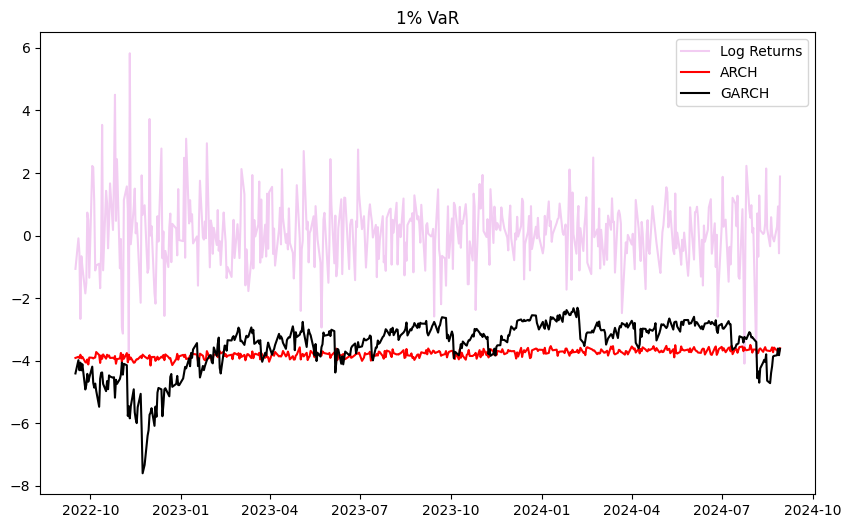

In [79]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-491:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var1_h10, 'r', label = 'ARCH') # negative sign just for revieing the graph 
plt.plot(-fgarch_var1_h10, 'k', label = 'GARCH')

plt.title('1% VaR')
plt.legend()
plt.show()

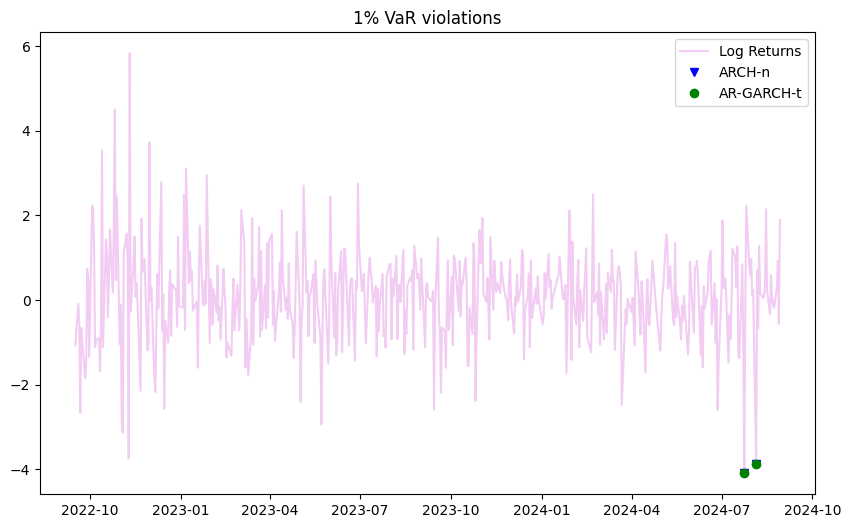

In [80]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-491:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-491:][r[-491:] < -farch_var1_h10], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-491:][r[-491:] < -fgarch_var1_h10], 'o', color='green', label='AR-GARCH-t')

plt.legend()
plt.title('1% VaR violations')
plt.show()

In [81]:
# forecast accuracy checks 
tbl_var1_h10 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var1_h10, r[-491:], 0.01),
    'AR-GARCH-t': check_var_fc(fgarch_var1_h10, r[-491:],0.01)},
     index = ['Viol.(5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var1_h10.insert(0, 'Horizon', [10,10])
tbl_var1_h10.round(4)

,Horizon,Viol.(5),$\hat{p}$,UC,Ind,DQ,Q Loss
ARCH-n,10,2.0,0.0041,0.1869,NaN,0.8792,19.6517
AR-GARCH-t,10,2.0,0.0041,0.1869,NaN,0.9897,18.9117


- 2.5% VaR

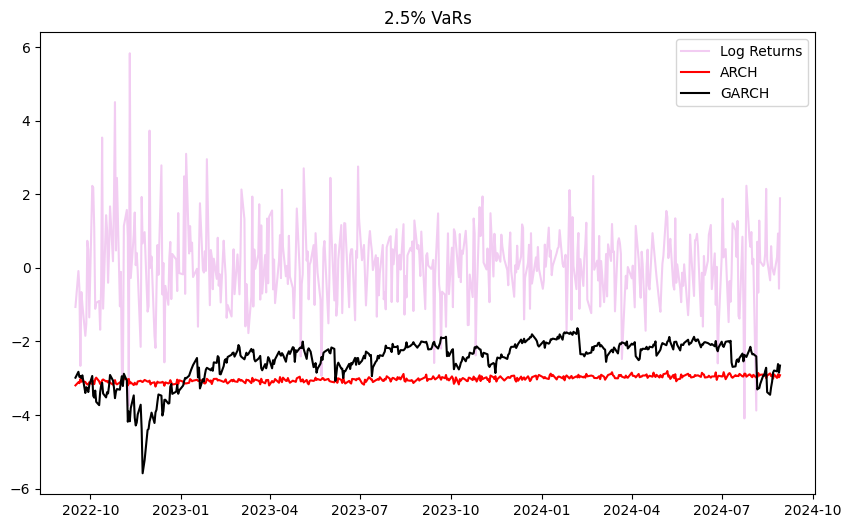

In [82]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-491:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var25_h10, 'r', label = 'ARCH') 
plt.plot(-fgarch_var25_h10, 'k', label = 'GARCH')

plt.title('2.5% VaRs')
plt.legend()
plt.show()

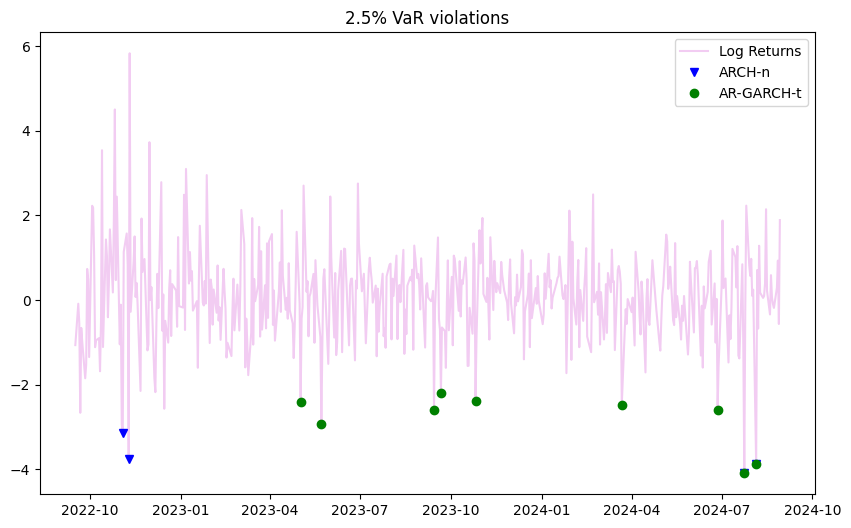

In [83]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-491:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-491:][r[-491:] < -farch_var25_h10], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-491:][r[-491:] < -fgarch_var25_h10], 'o', color='green', label='AR-GARCH-t')

plt.legend()
plt.title('2.5% VaR violations')
plt.show()

In [84]:
# forecast accuracy checks 
tbl_var25_h10 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var25_h10, r[-491:], 0.025),
    'AR-GARCH-t': check_var_fc(fgarch_var25_h10, r[-491:],0.025)},
     index = ['Viol.(12.5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var25_h10.insert(0, 'Horizon', [10,10])
tbl_var25_h10.round(4)

,Horizon,Viol.(12.5),$\hat{p}$,UC,Ind,DQ,Q Loss
ARCH-n,10,4.0,0.0081,0.0168,NaN,0.0835,40.8584
AR-GARCH-t,10,9.0,0.0183,0.3438,NaN,0.1360,37.5512


##### 22-steps ahead  
- 1% VaR 

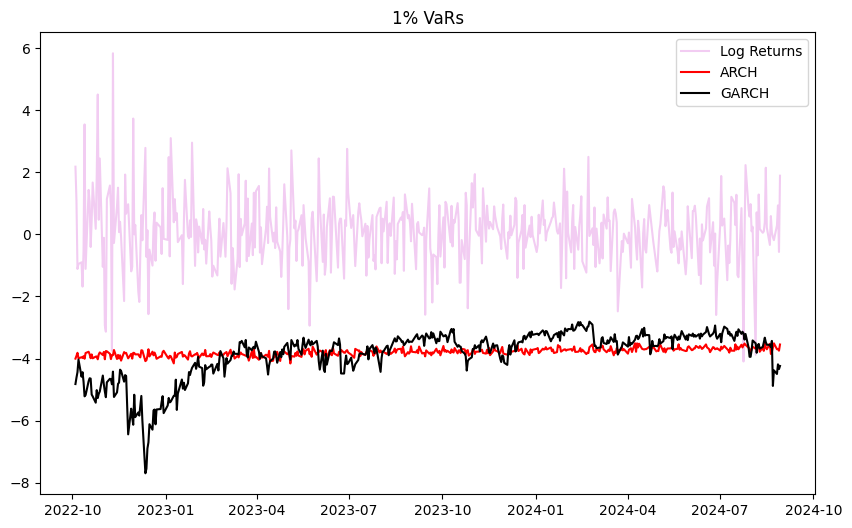

In [85]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-479:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var1_h22, 'r', label = 'ARCH') 
plt.plot(-fgarch_var1_h22, 'k', label = 'GARCH')

plt.title('1% VaRs')
plt.legend()
plt.show()

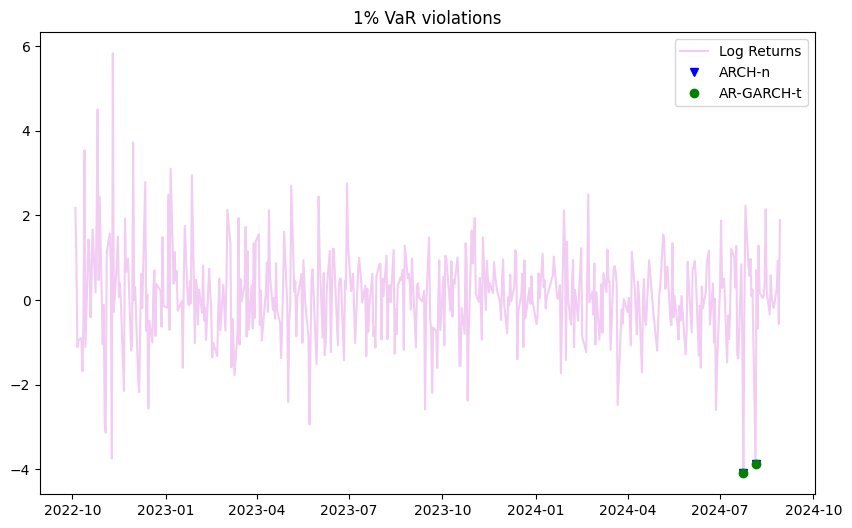

In [86]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-479:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-479:][r[-479:] < -farch_var1_h22], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-479:][r[-479:] < -fgarch_var1_h22], 'o', color='green', label='AR-GARCH-t')

plt.legend()
plt.title('1% VaR violations')
plt.show()

In [87]:
# forecast accuracy checks 
tbl_var1_h22 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var1_h22, r[-479:], 0.01),
    'AR-GARCH-t': check_var_fc(fgarch_var1_h22, r[-479:],0.01)},
     index = ['Viol.(5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var1_h22.insert(0, 'Horizon', [22,22])
tbl_var1_h22.round(4)
    

,Horizon,Viol.(5),$\hat{p}$,UC,Ind,DQ,Q Loss
ARCH-n,22,2.0,0.0042,0.2001,NaN,0.8782,19.2653
AR-GARCH-t,22,2.0,0.0042,0.2001,NaN,0.9749,20.1460


- 2.5% VaR 

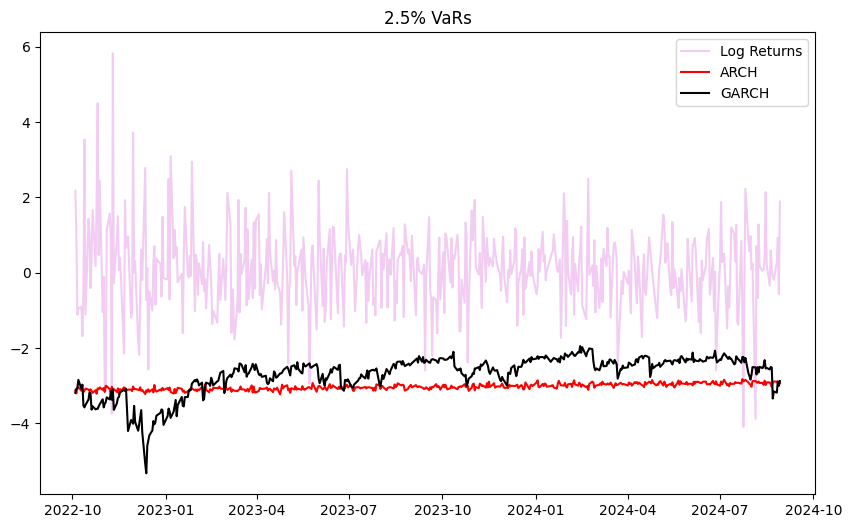

In [88]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-479:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_var25_h22, 'r', label = 'ARCH') 
plt.plot(-fgarch_var25_h22, 'k', label = 'GARCH')

plt.title('2.5% VaRs')
plt.legend()
plt.show()

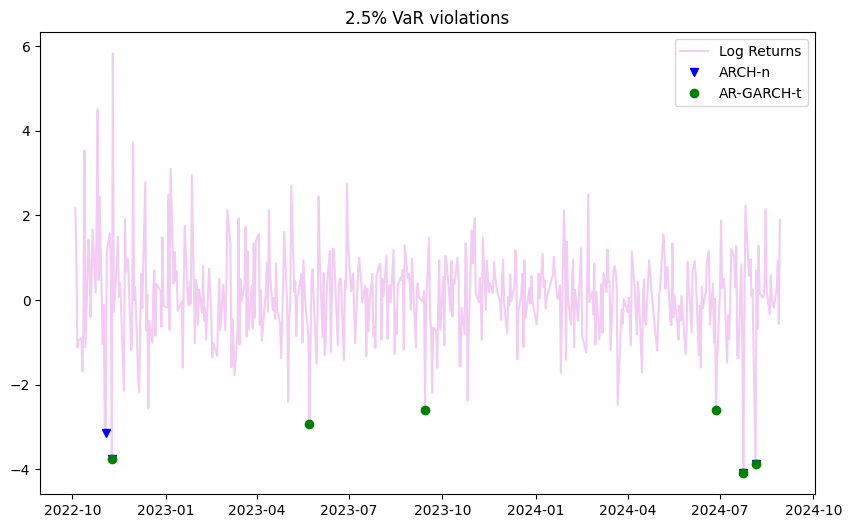

In [89]:
# violations 
plt.figure(figsize = (10, 6))
plt.plot(r[-479:],'m-', alpha = 0.2, label = 'Log Returns')

plt.plot(r[-479:][r[-479:] < -farch_var25_h22], 'v', color='blue', label='ARCH-n')  
plt.plot(r[-479:][r[-479:] < -fgarch_var25_h22], 'o', color='green', label='AR-GARCH-t')

plt.legend()
plt.title('2.5% VaR violations')
plt.show()

In [90]:
# forecast accuracy checks 
tbl_var25_h22 = pd.DataFrame({
    'ARCH-n': check_var_fc(farch_var25_h22, r[-479:], 0.025),
    'AR-GARCH-t': check_var_fc(fgarch_var25_h22, r[-479:],0.025)},
     index = ['Viol.(12.5)','$\hat{p}$', 'UC','Ind','DQ','Q Loss']).T
tbl_var25_h22.insert(0, 'Horizon', [22,22])
tbl_var25_h22.round(4)

,Horizon,Viol.(12.5),$\hat{p}$,UC,Ind,DQ,Q Loss
ARCH-n,22,4.0,0.0084,0.0196,NaN,0.0587,40.3635
AR-GARCH-t,22,6.0,0.0125,0.0804,NaN,0.7256,38.0275


In [91]:
# Summary for 1% VaR forecast

tbl_var1_all = pd.concat([tbl_var1, tbl_var1_h10,tbl_var1_h22])
tbl_var1_all.reset_index(names=['Module'], inplace=True)
tbl_var1_all = tbl_var1_all.groupby(['Horizon','Module']).mean()
tbl_var1_all.round(4)

Viol.(5)  $\hat{p}$      UC  Ind      DQ   Q Loss
Horizon Module                                                       
1       AR-GARCH-t       0.0     0.0000  0.0246  NaN     NaN  15.5754
        ARCH-n           0.0     0.0000  0.0246  NaN     NaN  16.2551
10      AR-GARCH-t       2.0     0.0041  0.1869  NaN  0.9897  18.9117
        ARCH-n           2.0     0.0041  0.1869  NaN  0.8792  19.6517
22      AR-GARCH-t       2.0     0.0042  0.2001  NaN  0.9749  20.1460
        ARCH-n           2.0     0.0042  0.2001  NaN  0.8782  19.2653

In [92]:
# Summary for 2.5% VaR forecast

tbl_var25_all = pd.concat([tbl_var25, tbl_var25_h10,tbl_var25_h22])
tbl_var25_all.reset_index(names=['Module'], inplace=True)
tbl_var25_all = tbl_var25_all.groupby(['Horizon','Module']).mean()
tbl_var25_all.round(4)

Viol.(12.5)  $\hat{p}$      UC  Ind      DQ   Q Loss
Horizon Module                                                          
1       AR-GARCH-t         10.0     0.0200  0.4739  NaN  0.1107  32.5228
        ARCH-n              0.0     0.0000  0.0003  NaN     NaN  34.1601
10      AR-GARCH-t          9.0     0.0183  0.3438  NaN  0.1360  37.5512
        ARCH-n              4.0     0.0081  0.0168  NaN  0.0835  40.8584
22      AR-GARCH-t          6.0     0.0125  0.0804  NaN  0.7256  38.0275
        ARCH-n              4.0     0.0084  0.0196  NaN  0.0587  40.3635

# Expected Shortfall (ES)

In [93]:
def jointloss(es,q,r,p):
    m = len(r)
    q = np.array(q)
    es = np.array(es)
    i1 = (r<q).astype(int)
    aes = es** (-1)*(p-1)
    ees = (r-q) * (p-i1)
    l = -np.log(aes)-ees/es/p
    return l

##### 1-step ahead  
- 1% ES 

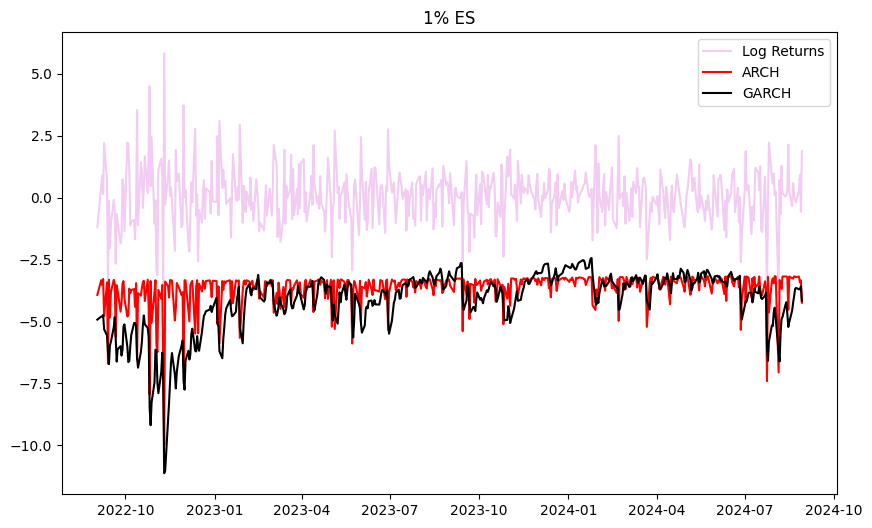

In [94]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-500:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_es1, 'r', label = 'ARCH')  
plt.plot(-fgarch_es1, 'k', label = 'GARCH')

plt.title('1% ES')
plt.legend()
plt.show()

In [95]:
fz_arch_1 = jointloss(-farch_es1, -farch_var1, r[-500:],0.01)
fz_garch_1 = jointloss(-farch_es1, -fgarch_var1, r[-500:],0.01)

print(np.mean(fz_arch_1))
print(np.mean(fz_garch_1))

2.1849411768709546
2.1521255401448505


##### Comment: The Fissler Ziegler loss for the GARCH model is slightly lower than the ARCH model, whic implies that the GARCH model is better for 1-day ahead 1% ES forecasting. 



- 2.5% ES 

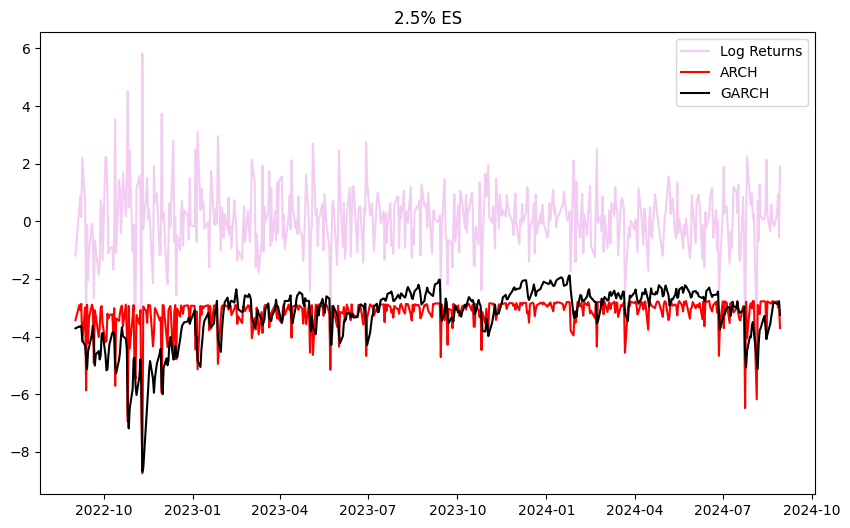

In [96]:
# plot 
plt.figure(figsize = (10,6))
plt.plot(r[-500:], 'm-', alpha = 0.2, label ='Log Returns')
plt.plot(-farch_es25, 'r', label = 'ARCH')  
plt.plot(-fgarch_es25, 'k', label = 'GARCH')

plt.title('2.5% ES')
plt.legend()
plt.show()

In [97]:
fz_arch_25 = jointloss(-farch_es25, -farch_var25, r[-500:],0.025)
fz_garch_25 = jointloss(-farch_es25, -fgarch_var25, r[-500:],0.025)

print(np.mean(fz_arch_25))
print(np.mean(fz_garch_25))

2.031835562777571
1.9603026785387943


##### Comment: In this case, the Fissler Ziegler loss for the GARCH model is still lower than the ARCH model, whic implies that the GARCH model is still better for 1-day ahead 5% ES forecasting. 

##### 10-steps ahead  


In [98]:
# 1% ES 
fz_arch_1_h10 = jointloss(-farch_es1_h10, -farch_var1_h10, r[-491:],0.01)
fz_garch_1_h10 = jointloss(-farch_es1_h10, -fgarch_var1_h10, r[-491:],0.01)

print(np.mean(fz_arch_1_h10))
print(np.mean(fz_garch_1_h10))


# 2.5% ES 
fz_arch_25_h10 = jointloss(-farch_es25_h10, -farch_var25_h10, r[-491:],0.025)
fz_garch_25_h10 = jointloss(-farch_es25_h10, -fgarch_var25_h10, r[-491:],0.025)

print(np.mean(fz_arch_25_h10))
print(np.mean(fz_garch_25_h10))

2.4114915460636004
2.3790344461410995
2.241385402015129
2.17170220806687


##### 22-steps ahead  

In [99]:
# 1% ES 
fz_arch_1_h22 = jointloss(-farch_es1_h22, -farch_var1_h22, r[-479:],0.01)
fz_garch_1_h22 = jointloss(-farch_es1_h22, -fgarch_var1_h22, r[-479:],0.01)

print(np.mean(fz_arch_1_h22))
print(np.mean(fz_garch_1_h22))


# 2.5% ES 
fz_arch_25_h22 = jointloss(-farch_es25_h22, -farch_var25_h22, r[-479:],0.025)
fz_garch_25_h22 = jointloss(-farch_es25_h22, -fgarch_var25_h22, r[-479:],0.025)

print(np.mean(fz_arch_25_h22))
print(np.mean(fz_garch_25_h22))

2.413400597153887
2.449968387093717
2.2506054705721703
2.1995538203080027


### 2)Compare AR(1)-N with a constant mean to a AR(6)-GARCH(3,7)-T  
Apply Proxy2 

In [100]:
# Total 
number_all = len (proxy2)

# Number of windows
number_wind = 500

# Size of each window
size_wind = number_all - number_wind

##### 1-step Ahead Forecast

In [101]:
# AR(1)- N
far_mean = pd.Series(index = proxy2[-number_wind:].index, dtype = 'float64')

# AR(6)-GARCH(3,7)-T 
fgarch_mean = pd.Series(index = proxy2[-number_wind:].index, dtype = 'float64')


# Expanding Window
for i in tqdm(range(number_wind)): 
    train = proxy2[:(size_wind+i+1)]

    #AR(1)-n
    res_AR1_n = arch_model(train, mean = 'AR', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off')
    fc_AR1_n = res_AR1_n.forecast(horizon = 1, reindex = False)   
    # Result 
    mean = fc_AR1_n.mean   
    # Storge 
    far_mean[i] = mean.iloc[0,0]
    
    
    # AR(6)-GARCH(3,7)-t
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 1, reindex = False)  
    # Result 
    mean = fc_AR6_GARCH37_t.mean
    df = res_AR6_GARCH37_t.params['nu'] 
    # Storge 
    fgarch_mean[i] = mean.iloc[0,0]
    fgarch_df[i] = df

  0%|          | 0/500 [00:00<?, ?it/s]

##### 10-step Ahead Forcast

In [102]:
# AR(1)-N 
far_mean_h10 = pd.Series(index = proxy2[-number_wind+9:].index, dtype = 'float64')


# AR(8)-GARCH(3,7)-T
fgarch_mean_h10 = pd.Series(index = proxy2[-number_wind+9:].index, dtype = 'float64')
# store the value of degree of freedom as we use t-distribution 
fgarch_df_h10 = pd.Series(index = proxy2[-number_wind+9:].index, dtype = 'float64')

#Number of future scenarios to stimulate  Since we don't know the joint distrubution, we need to stimulate 
B = 10000


# Expanding Window
for i in tqdm(range(number_wind-9)): 
    train = proxy2[:(size_wind+i+1)]

    #AR(1)-n
    res_AR1_n = arch_model(train, mean = 'AR', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off')
    fc_AR1_n = res_AR1_n.forecast(horizon = 10, method = 'simulation', simulations = B, reindex = False)
    # Result 
    mean = fc_AR1_n.mean[['h.10']]

    # Storge 
    far_mean_h10[i] = mean.iloc[0,0]

    # AR(6)-GARCH(3,7)-t
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 10, method = 'simulation', simulations = B, reindex = False)
    
    # Result 
    mean = fc_AR6_GARCH37_t.mean[['h.10']]
    df = res_AR6_GARCH37_t.params['nu']
    simvals = fc_AR6_GARCH37_t.simulations.values[0,:,9]

    # Storge 
    fgarch_mean_h10[i] = mean.iloc[0,0]
    fgarch_df_h10[i] = df

  0%|          | 0/491 [00:00<?, ?it/s]

##### 22-step Ahead Forcast

In [103]:
# AR(1)-N
far_mean_h22 = pd.Series(index = proxy2[-number_wind+21:].index, dtype = 'float64')


# AR(6)-GARCH(3,7)-T 
fgarch_mean_h22 = pd.Series(index = proxy2[-number_wind+21:].index, dtype = 'float64')
# store the value of degree of freedom as we use t-distribution 
fgarch_df_h22 = pd.Series(index = proxy2[-number_wind+21:].index, dtype = 'float64')

# Number of future scenarios to stimulate
B = 10000


# Expanding Window
for i in tqdm(range(number_wind-21)): 
    train = proxy2[:(size_wind+i+1)]

    #AR(1)-n
    res_AR1_n = arch_model(train, mean = 'AR', vol = 'ARCH', p=1, q=0, dist='Normal').fit(disp='off')
    fc_AR1_n = res_AR1_n.forecast(horizon = 22, method = 'simulation', simulations = B, reindex = False)
    # Result 
    mean = fc_AR1_n.mean[['h.22']]
    # Storge 
    far_mean_h22[i] = mean.iloc[0,0]

    
    # AR(6)-GARCH(3,7)-t
    res_AR6_GARCH37_t = arch_model(train, mean = 'AR', lags = 6, vol = 'GARCH', p=3, q=7, dist='StudentsT').fit(disp='off')
    fc_AR6_GARCH37_t = res_AR6_GARCH37_t.forecast(horizon = 22, method = 'simulation', simulations = B, reindex = False)    
    # Result 
    mean = fc_AR6_GARCH37_t.mean[['h.22']]
    df = res_AR6_GARCH37_t.params['nu']
    simvals = fc_AR6_GARCH37_t.simulations.values[0,:,21]
    # Storge 
    fgarch_mean_h22[i] = mean.iloc[0,0]
    fgarch_df_h22[i] = df

  0%|          | 0/479 [00:00<?, ?it/s]

# Validation

##### Given that proxy2 is already a volatility proxy, specifically derived from Parkinson’s range-based volatility measure, it inherently captures the volatility dynamics of the underlying asset. Since proxy2 serves as a direct representation of the asset's volatility, further calculating risk metrics such as Value at Risk (VaR), Expected Shortfall (ES), or the variance of volatility using the same proxy would be redundant. Therefore, we just focus on the mean validation. 

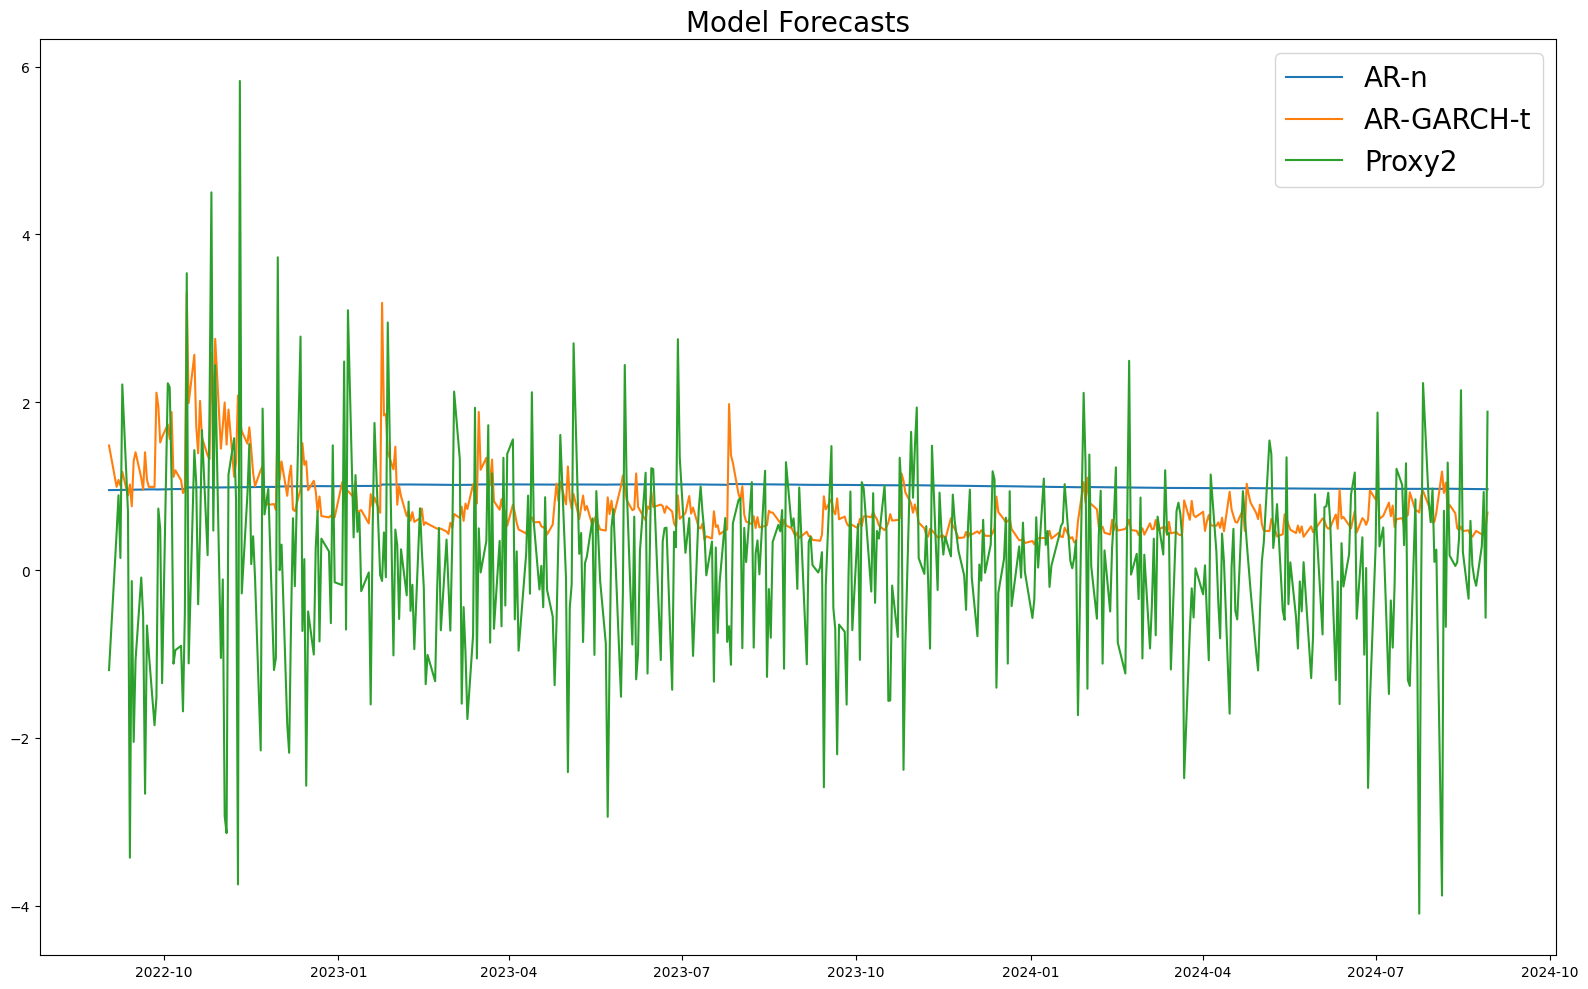

In [104]:
# 1-step ahead 
y_val = r[-500:]

# plot 
plt.figure(figsize = (16,10))
plt.plot(far_mean, label = 'AR-n')
plt.plot(fgarch_mean, label = 'AR-GARCH-t')
plt.plot(y_val, label = 'Proxy2')
plt.title('Model Forecasts', fontsize=20)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()

# RMSE
rmse_ar_mean = np.sqrt(np.mean((y_val-far_mean)**2))
rmse_garch_mean = np.sqrt(np.mean((y_val-fgarch_mean)**2))

In [105]:
# 10-steps ahead 
y_val = r[-491:]

# RMSE
rmse_ar_mean_h10 = np.sqrt(np.mean((y_val - far_mean_h10)**2))
rmse_garch_mean_h10 = np.sqrt(np.mean((y_val-fgarch_mean_h10)**2))

# 22-steps ahead 
y_val = r[-479:]

# RMSE
rmse_ar_mean_h22 = np.sqrt(np.mean((y_val-far_mean_h22)**2))
rmse_garch_mean_h22 = np.sqrt(np.mean((y_val-fgarch_mean_h22)**2))

In [107]:
mdl_name = ['AR-n','AR-GARCH-t']
horizon = [1,10,22]
rmse = [[rmse_ar_mean,rmse_garch_mean],
        [rmse_ar_mean_h10,rmse_garch_mean_h10],
        [rmse_ar_mean_h22,rmse_garch_mean_h22],]
tbl_rmse_mean = pd.DataFrame(rmse, index = horizon, columns = mdl_name)
tbl_rmse_mean.index.name = 'Horizon'
tbl_rmse_mean.round(4)

,AR-n,AR-GARCH-t
Horizon,,
1,1.4634,1.3676
10,1.4514,1.1835
22,1.4348,1.1578


##### Conclusion: 

- The RMSE of the AR-GARCH-t model performs better than the AR-n model on all steps, especially on the long-term prediction of 10-step and 22-step, which is related to the GARCH model's ability to dynamically capture volatility. Therefore, these results are in line with our expectation that the GARCH model is better suited to handle time series volatility.

- As the time step increased, the RMSE of both models showed a gradual decline, especially the AR-GARCH-t model, which means that its performance was more stable over a longer time span.